# **Projet 6. Analysez les ventes d'une librairie avec R ou Python**

## **Table des matières** 

* [Mission 0. Préparation et exploration des données](#chapter1)
    * [1. Importation des données](#section_1_1)
    * [2. Analyse des tableaux](#section_1_2)
    * [3. Transactions de test](#section_1_3)
    * [4. Clients inactifs](#section_1_4)
    * [5. Produits que l'on n'achète jamais](#section_1_5)
    * [6. Fusionnage des tableaux](#section_1_6)
    * [7. Catégories de livres](#section_1_7)
    * [8. Prix manquant pour le produit id = 0_2245 ](#section_1_8)
    * [9. Création de nouvelles colonnes et définition du format](#section_1_9)
    * [10. Enregistrement des tableaux nettoyés](#section_1_10)
    * [11. Résultats du nettoyage des données](#section_1_11)
* [Mission 1. Mission de Antoine. Analyse des différents indicateurs de vente](#chapter2)
    * [1. Chiffre d'affaires et son évolution dans le temps](#section_2_1)
    * [2. Analyse multivariée du chiffre d'affaires](#section_2_2)
    * [3. La répartition du chiffre d'affaires entre les clients](#section_2_3)
* [Mission 2. Mission de Julie. Analyse ciblée sur les clients](#chapter3)
    * [1. Le lien entre le genre d’un client et les catégories des livres achetés](#section_3_1)
    * [2. Le lien entre l’âge des clients et les autres variables](#section_3_2)
    * [3. Les statistiques par tranche d’âge](#section_3_3)
    * [4. La probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159](#section_3_4)
* [Extra](#chapter4)
* [Conclusion](#chapter5)

## **Mission 0. Préparation et exploration des données** <a class="anchor" id="chapter1"></a>

### **1. Importation des données**<a class="anchor" id="section_1_1"></a>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines #légende
import matplotlib.ticker as ticker #y axis format
import matplotlib.style as style #style de graphiques
plt.style.use('seaborn-pastel')
import seaborn as sns
from IPython.display import display #tableaux format
import scipy.stats as st #tests statistiques
import scipy.optimize #régressions
from sklearn.linear_model import LinearRegression #régressions
from statsmodels.graphics.tsaplots import plot_acf #ACF
from statsmodels.graphics.tsaplots import plot_pacf #PACF
from pylab import rcParams #changer taille de graphiques par défaut
import statsmodels.tsa.api as smt #prédictions
import statsmodels.api as sm #prédictions
import itertools #combinations
import locale #dates français
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

'fr_FR.UTF-8'

In [ ]:
customers=pd.read_csv('customers.csv', parse_dates=[2], header=0)
customers['birth']=customers['birth'].dt.year
transactions=pd.read_csv('transactions.csv', parse_dates=[1], header=0)
products=pd.read_csv('products.csv', header=0)

### **2. Analyse des tableaux**<a class="anchor" id="section_1_2"></a>

In [ ]:
transactions.describe(include='all')

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


### Le tableau transactions:
**Nombre de lignes et de colonnes:** 679,532 lignes et 4 colonnes 
<br>
**Type de variables:** qualitatives seulement (id_prod, date, session_id, client_id)
<br>
&emsp;&emsp;Variable id_prod: 3,267 valeurs uniques, ce qui nous indique que le même livre a été vendu plusieurs fois, ce qui est logique<br>
&emsp;&emsp;Variable date: il y a un problème avec les valeurs de cette colonne, elle n'a pas été lue comme une porteuse des dates ; avec le 'describe' on voit bien la valeur 'test_2021-03-01 02:30:02.237413' qui peut être la raison du problème<br>
&emsp;&emsp;Variable session_id: 342,316 valeurs uniques, c'est-à-dire une session peut être composée de plusieurs produits <br>
&emsp;&emsp;Variable client_id: 8,602 valeurs uniques, ce qui nous indique que le même client a visité et a acheté quelque chose plusieurs fois, ce qui est également logique <br>
**Analyse des valeurs manquantes:** aucune


In [ ]:
customers.describe(include='all')

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_3658,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


### Le tableau customers:
**Nombre de lignes et de colonnes:** 8,623 lignes et 3 colonnes 
<br>
**Type de variables:** qualitatives (client_id, sex), quantitative (birth)
<br>
&emsp;&emsp;Variable client_id: 8,623 valeurs uniques, pourrait jouer le rôle d'index pour le tableau, pourtant, nous avons des clients qui n'ont rien acheté depuis 2 ans, nous allons les exclure de notre analyse (~21 personnes)<br>
&emsp;&emsp;Variable sex: il y a deux sexes différents dans notre tableau: f (femme) et m (homme)<br>
&emsp;&emsp;Variable birth: nos client sont nés entre 1929 et 2004 (ils ont 19-94 ans en 2023)<br>
**Analyse des valeurs manquantes:** aucune


In [ ]:
products.describe(include='all')

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_2303,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


### Le tableau products:
**Nombre de lignes et de colonnes:** 3,287 lignes et 4 colonnes 
<br>
**Type de variables:** qualitative (id_prod), quantitatives (price, categ)
<br>
&emsp;&emsp;Variable id_prod: 3,287 valeurs uniques, pourrait jouer le rôle d'index pour le tableau, pourtant, nous avons des livres qui n'ont jamais été vendus depuis 2 ans, nous allons les exclure de notre analyse (~20 livres)<br>
&emsp;&emsp;Variable price: le prix minimum est égal à -1, ce qui est une anomalie à étudier, le prix maximum est égal à 300 euros<br>
&emsp;&emsp;Variable categ: nous avons 3 catégories de livres: 0, 1, 2<br>
**Analyse des valeurs manquantes:** aucune


### **3. Transactions de test**<a class="anchor" id="section_1_3"></a>

In [ ]:
# on cherche les produits avec le prix anormal
products[products['price']<=0]

,id_prod,price,categ
731,T_0,-1.0,0


In [ ]:
transactions[transactions['id_prod']=='T_0']

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


Toutes les transactions avec le produit T_0 sont des transactions d'essai. Ces transactions ont eu lieu le 1 mars 2021 (la date d'ouverture de magasin en ligne). Nous n'avons pas besoin de ces données pour notre analyse. Donc, on peut les supprimer. 

In [ ]:
# on supprime les transactions d'essai
transactions=transactions[transactions['id_prod']!='T_0']
products=products[products['id_prod']!='T_0']

### **4. Clients inactifs**<a class="anchor" id="section_1_4"></a>

In [ ]:
# on va afficher les données sur nos clients inactifs 
# (les client qui existent dans le tableau customers, mais pas dans le tableau transactions)
clients_inactifs=customers[~customers.client_id.isin(transactions.client_id.unique().tolist())].copy()
clients_inactifs['age']=2023-clients_inactifs['birth']
print('Total nombre de cliets inactifs :', len(clients_inactifs))
clients_inactifs.sort_values(['age', 'sex'])

Total nombre de cliets inactifs : 23


,client_id,sex,birth,age
6208,c_5245,f,2004,19
3721,c_6930,m,2004,19
6471,c_6735,m,2004,19
6338,c_5223,m,2003,20
6112,c_6862,f,2002,21
801,c_8253,f,2001,22
2735,ct_0,f,2001,22
7790,c_90,m,2001,22
8494,ct_1,m,2001,22
3821,c_4358,m,1999,24


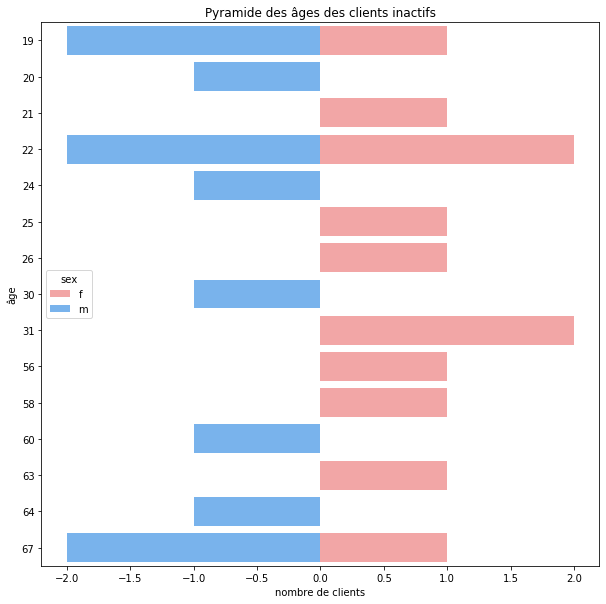

In [ ]:
# on va dessiner un graphique pour mieux voir leur âge et leur sexe
cust_sex=clients_inactifs.groupby(['age', 'sex']).agg({'birth': 'count'}).rename(columns={'birth': 'nombre de clients'})
cust_sex.reset_index(inplace=True)
cust_sex.loc[cust_sex['sex']=='m', 'nombre de clients']=cust_sex.loc[cust_sex['sex']=='m', 'nombre de clients']*(-1)
plt.figure(figsize=(10,10))
sns.barplot(data=cust_sex, x='nombre de clients',y='age',
            hue='sex',orient='horizontal', palette=['#ff9999', '#66b3ff'],
            dodge=False)
plt.ylabel('âge')
plt.title('Pyramide des âges des clients inactifs')
#plt.savefig('LaPage1.png', transparent=True)
plt.show()

Ces 23 clients n'ont jamais acheté de livres sur notre site web. Je peut supposer que ces clients préfèrent acheter des livres à une librairie physique. Ces clients sont d'âges différents, donc il est difficile de voir une tendance. Peut-être ces clients ne savent pas que notre librairie a ouvert un site de vente en ligne (dans ce cas il faut les contacter par e-mail, si on a leurs adresses mails), ou c'est aussi possible que ces clients ont deux comptes et n'en utilise qu'un.
Je vais supprimer ces clients de mon analyse.

In [ ]:
# on supprime ces clients du tableau customers
customers=customers[customers.client_id.isin(transactions.client_id.unique().tolist())]

### **5. Produits que l'on n'achète jamais**<a class="anchor" id="section_1_5"></a>

In [ ]:
# on va afficher les produits que nos clients n'achètent pas 
# (les produits qui existent dans le tableau products, mais pas dans le tableau transactions)
produit_non_vendus=products[~products.id_prod.isin(transactions.id_prod.unique().tolist())].copy()
print('Total nombre de produits que l\'on n\'achète jamais :', len(produit_non_vendus))
produit_non_vendus.sort_values('price')

Total nombre de produits que l'on n'achète jamais : 21


,id_prod,price,categ
1530,0_1620,0.80,0
811,0_1014,1.15,0
279,0_1780,1.67,0
2215,0_310,1.94,0
794,0_1119,2.99,0
1505,0_322,2.99,0
1347,0_1645,2.99,0
737,0_1062,20.08,0
3096,0_2308,20.28,0
1031,0_1318,20.92,0


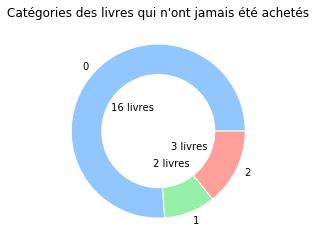

In [ ]:
# fonction pour afficher les valeurs de segments
def func(pct, allvals):
    absolute = int(pct/100.*len(allvals))
    return "{:d} livres".format(absolute)


fig, ax = plt.subplots()
wedges, text, autotext = ax.pie([16, 2, 3], labels=[0, 1, 2], labeldistance=1.1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct=lambda pct: func(pct, produit_non_vendus['categ']), pctdistance=0.4)
# pour avoir un donut 
plt.setp( wedges, width=0.35)
plt.title('Catégories des livres qui n\'ont jamais été achetés')
#plt.savefig('LaPage2+.png', transparent=True, bbox_inches='tight')
plt.show()

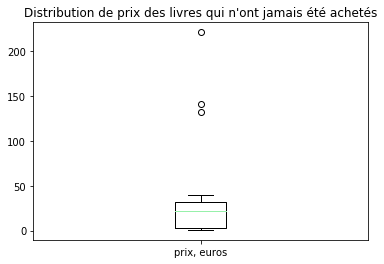

In [ ]:
# graphique avec la distribution des prix de ces produits
plt.boxplot(produit_non_vendus['price'])
plt.xticks([1], ['prix, euros'])
plt.title('Distribution de prix des livres qui n\'ont jamais été achetés')
plt.savefig('LaPage2.png', transparent=True)
plt.show()

Nous avons 21 livres qui apparemment n'intéressent pas nos clients :<br>
&emsp;&emsp;3 livres de la catégorie 2,<br>
&emsp;&emsp;2 livres de la catégorie 1,<br>
&emsp;&emsp;16 livres de la catégorie 0.<br>
Les prix varient de 0.8 à 221 euros. Donc, il faut analyser ces livres plus profondément pour trouver la raison pour laquelle ces livres ne sont pas vendus. Après un tel analyse on peut également prendre une décision de garder ces livres ou de ne plus les vendre.
Pour les buts de mon analyse je supprime ces données.

In [ ]:
# on supprime ces produits du tableau products
products=products[products.id_prod.isin(transactions.id_prod.unique().tolist())]

### **6. Fusionnage des tableaux**<a class="anchor" id="section_1_6"></a>

In [ ]:
# on fusionne les trois tableaux, on renomme plusieurs colonnes : 
# pour les colonnes du tableau customers on ajoute 'client_' au début
# pour les colonnes du tableau products on ajoute 'product_' au début
lapage_data=pd.merge(pd.merge(transactions, customers, how='left', on='client_id'), 
                     products, how='left', on='id_prod').rename(columns={'sex': 'client_sex', 'birth': 'client_birth', 'price': 'product_price', 'categ': 'product_categ'})

### **7. Catégories de livres** <a class="anchor" id="section_1_7"></a>

In [ ]:
# je veux vérifier ma théorie qu'il y a un lien entre le premier chiffre du id_prod et la catégorie de produit
cat_0 = products.apply(lambda x: x['id_prod'].startswith('0_'), axis=1)
cat_1 = products.apply(lambda x: x['id_prod'].startswith('1_'), axis=1)
cat_2 = products.apply(lambda x: x['id_prod'].startswith('2_'), axis=1)
print('Commencent par 0_ les produits de catégorie :', *products[cat_0]['categ'].unique())
print('Commencent par 1_ les produits de catégorie :', *products[cat_1]['categ'].unique())
print('Commencent par 2_ les produits de catégorie :', *products[cat_2]['categ'].unique())

Commencent par 0_ les produits de catégorie : 0
Commencent par 1_ les produits de catégorie : 1
Commencent par 2_ les produits de catégorie : 2


Donc, il y a un lien entre le nom du produit et sa catégorie.

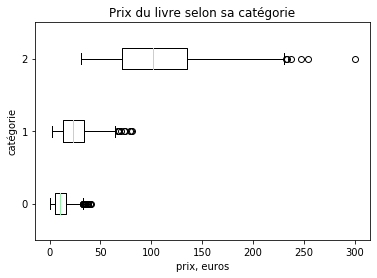

In [ ]:
# voyons maintenant la distribution des prix pour chaque catégorie de livres
fig, ax = plt.subplots()
ax.boxplot([products[cat_0]['price'], products[cat_1]['price'], products[cat_2]['price']], vert=False)
ax.set_yticklabels(['0', '1', '2'])
plt.title('Prix du livre selon sa catégorie')
plt.xlabel('prix, euros')
plt.ylabel('catégorie')
#plt.savefig('LaPage3.png', transparent=True)
plt.show()


Pour la catégorie 0 la fourchette de prix est la plus petite. Pour la catégorie 2 elle est la plus grande.

### <font color='red'>Test de normalité</font> 

In [ ]:
# on teste l'hypothèse nulle que le prix par catégorie suit une loi normale 
print(st.normaltest(products[cat_0]['price']))
print(st.normaltest(products[cat_1]['price']))
print(st.normaltest(products[cat_2]['price']))

NormaltestResult(statistic=220.61616457905185, pvalue=1.2411050773938311e-48)
NormaltestResult(statistic=67.6049214209327, pvalue=2.0882276345246948e-15)
NormaltestResult(statistic=32.79908136353467, pvalue=7.546923993657454e-08)


pvalue < 0,05, on rejette très largement l'hypothèse de normalité au niveau de test 5%.

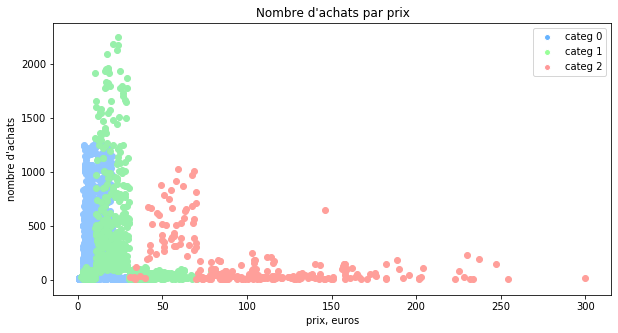

In [ ]:
# on va analyser s'il y a un lien entre le prix de livre et le nombre de ventes de ce livre
# on va également colorer les livres selon leur catégorie
categorie_0=lapage_data[(lapage_data['product_categ']==0) & (~lapage_data['product_price'].isna())]
categorie_1=lapage_data[(lapage_data['product_categ']==1) & (~lapage_data['product_price'].isna())]
categorie_2=lapage_data[(lapage_data['product_categ']==2) & (~lapage_data['product_price'].isna())]
cat_0=categorie_0[['id_prod', 'session_id', 'product_price']].groupby('id_prod').agg({'session_id':'count', 'product_price': 'first'})
cat_1=categorie_1[['id_prod', 'session_id', 'product_price']].groupby('id_prod').agg({'session_id':'count', 'product_price': 'first'})
cat_2=categorie_2[['id_prod', 'session_id', 'product_price']].groupby('id_prod').agg({'session_id':'count', 'product_price': 'first'})

plt.figure(figsize=(10,5))
plt.scatter(cat_0.product_price, cat_0.session_id)
plt.scatter(cat_1.product_price, cat_1.session_id)
plt.scatter(cat_2.product_price, cat_2.session_id)
plt.title('Nombre d\'achats par prix')
plt.ylabel('nombre d\'achats')
plt.xlabel('prix, euros')

line1 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor='#66b3ff')
line2 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor='#99ff99')
line3 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor='#ff9999')
plt.legend((line1,line2,line3),('categ 0','categ 1', 'categ 2'), numpoints=1, loc='upper right')
#plt.savefig('LaPage4.png', transparent=True)
plt.show()


Les livres que l'on achète plus souvent sont ceux qui coûtent moins cher et vice versa. 
Les plus populaires sont les livres des catégories 0 et 1 qui coûtent 0-25 euros.
Car les livres de la catégorie 2 sont plus chers en général, on voit que ces livres sont plus souvent achetés s'ils coûtent autour de 50 euros.

### **8. Prix manquant pour le produit id = 0_2245**<a class="anchor" id="section_1_8"></a>

In [ ]:
# on vérifie s'il a des lignes avec des valeurs manquantes
lapage_data[lapage_data.isnull().any(axis=1)]

,id_prod,date,session_id,client_id,client_sex,client_birth,product_price,product_categ
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,m,1940,NaN,NaN
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,f,1963,NaN,NaN
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,m,1978,NaN,NaN
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,m,1991,NaN,NaN
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,m,1973,NaN,NaN
...,...,...,...,...,...,...,...,...
669533,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,m,1981,NaN,NaN
670484,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,f,1979,NaN,NaN
671088,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,m,1981,NaN,NaN
675480,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,m,1986,NaN,NaN


In [ ]:
# combien de livres a-t-on pour lequels le prix est inconnu
lapage_data[lapage_data['product_price'].isna()]['id_prod'].unique()

array(['0_2245'], dtype=object)

Nous avons seulement un livre avec le prix (et la catégorie) manquant.

Le produit 0_2245 n'a pas d'information ni sur le prix ni sur la catégorie. Pourtant, on ne peut pas supprimer toutes les lignes avec ce produit, car il y a 221 lignes, ce qui n'est pas négligeable. Ce produit vient de la catégorie 0, car il commence par '0_'. Donc, d'abord, on va imputer '0' dans la colonne 'product_categ'.

In [ ]:
# on impute '0' dans la colonne 'product_categ' pour le livre 0_2245
lapage_data.loc[lapage_data['id_prod']=='0_2245', 'product_categ']=0

Pour trouver le prix du livre je vais utiliser plusieurs approches. 
D'abord on va vérifier s'il y a une corrélation entre le prix et le nombre d'achat du produit.

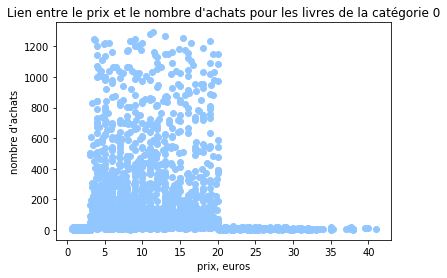

In [ ]:
# on dessine un graphique ou pour chaque livre on compte le nombre de ventes correspondantes et on met un point selon son prix
# chaque point correspond à un livre
categorie_0=lapage_data[(lapage_data['product_categ']==0) & (~lapage_data['product_price'].isna())]
cat_0=categorie_0[['id_prod', 'session_id', 'product_price']].groupby('id_prod').agg({'session_id':'count', 'product_price': 'first'})
plt.scatter(cat_0.product_price, cat_0.session_id)
plt.ylabel('nombre d\'achats')
plt.xlabel('prix, euros')
plt.title('Lien entre le prix et le nombre d\'achats pour les livres de la catégorie 0')
#plt.savefig('LaPage5.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# on calcule le coefficient de corrélation linéaire
st.pearsonr(cat_0.product_price, cat_0.session_id)[0]

-0.09412413873308118

In [ ]:
# on calcule le prix médian de livres qui ont été vendus 201-241 fois
print('median =', np.median(cat_0[(cat_0['session_id']>200) & (cat_0['session_id']<242)]['product_price']))

median = 8.99


Comme on peut le voir, il n'y a pas de correlation entre le prix et le nombre d'achats de livre. Donc, on ne peut pas utiliser le nombre d'achats (221) pour calculer le prix.

Ensuite, on va essayer de prendre les clients qui achètent le livre 0_2245 et calculer le prix moyen des autres livres qu'ils achètent.

median = 13.9


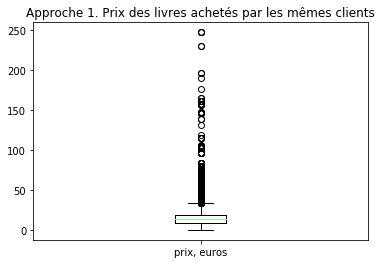

In [ ]:
# on va créer une graphique avec la distribution des prix des livres achétés par les même clients que le livre 0_2245
clients_0_2245=lapage_data[lapage_data['product_price'].isna()]['client_id'].unique().tolist()
print('median =', np.median(lapage_data[(lapage_data['client_id'].isin(clients_0_2245))  & (~lapage_data['product_price'].isna())]['product_price']))
plt.boxplot(lapage_data[(lapage_data['client_id'].isin(clients_0_2245))  & (~lapage_data['product_price'].isna())]['product_price'])
plt.xticks([1], ['prix, euros'])
plt.title('Approche 1. Prix des livres achetés par les mêmes clients')
#plt.savefig('LaPage6.png', transparent=True, bbox_inches='tight')
plt.show()

... et seulement pour les livres de la catégorie 0:

median = 9.99


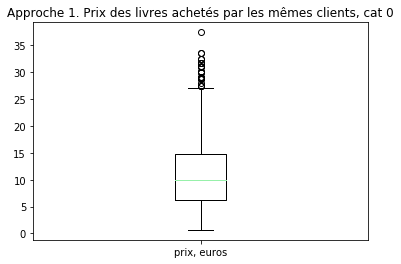

In [ ]:
# la distribution des prix des livres de la catégorie 0 achetés par les mêmes clients que le livre 0_2245
print('median =', np.median(lapage_data[(lapage_data['client_id'].isin(clients_0_2245))  & (lapage_data['product_categ']==0) & (~lapage_data['product_price'].isna())]['product_price']))
plt.boxplot(lapage_data[(lapage_data['client_id'].isin(clients_0_2245))  & (lapage_data['product_categ']==0) & (~lapage_data['product_price'].isna())]['product_price'])
plt.xticks([1], ['prix, euros'])
plt.title('Approche 1. Prix des livres achetés par les mêmes clients, cat 0')
#plt.savefig('LaPage7.png', transparent=True, bbox_inches='tight')
plt.show()

Les prix de ces livres varient trop, ce qui nous ne permet pas de déterminer le prix de livre 0_2245.

In [ ]:
# on vérifie s'il y a un lien entre le id_prod et le prix
products[products['categ']==0].sort_values('id_prod')

,id_prod,price,categ
1001,0_0,3.75,0
803,0_1,10.99,0
2691,0_10,17.95,0
663,0_100,20.60,0
922,0_1000,6.84,0
...,...,...,...
2626,0_995,10.99,0
1828,0_996,11.64,0
1740,0_997,9.99,0
548,0_998,9.41,0


Ici on peut voir que id_prod ne détermine pas de prix non plus.

Finalement, on va calculer le prix moyen pour tous les livres de la catégorie 0 que l'on a dans le magasin.

median = 10.305


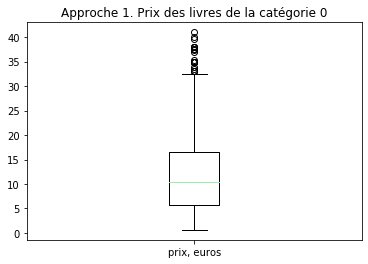

In [ ]:
# graphique avec la distribution de prix de tous les livres de la catégorie 0
print('median =', np.median(products[products['categ']==0]['price']))
plt.boxplot(products[products['categ']==0]['price'])
plt.xticks([1], ['prix, euros'])
plt.title('Approche 1. Prix des livres de la catégorie 0')
#plt.savefig('LaPage8.png', transparent=True, bbox_inches='tight')
plt.show()

Car on n'a pas pu trouver aucune corrélation entre le prix du produit et les autres variables que l'on a, on va utiliser le prix moyen des livres de la catégorie 0 que l'on a dans le magasin (€10,32).

In [ ]:
# on impute '10.32' dans la colonne 'product_price' pour le livre 0_2245
lapage_data.loc[lapage_data['id_prod']=='0_2245', 'product_price']=np.median(products[products['categ']==0]['price'])

In [ ]:
# on fait les mêmes imputations dans le tableau products pour le livre 0_2245
products = products.append(dict(zip(products.columns,['0_2245', np.median(products[products['categ']==0]['price']), 0])), ignore_index=True)

### **9. Création de nouvelles colonnes et définition du format**<a class="anchor" id="section_1_9"></a>

In [ ]:
#on convertit le format des colonnes date et product_categ
lapage_data['date'] = pd.to_datetime(lapage_data['date'], format='%Y-%m-%d %H:%M:%S')
lapage_data['product_categ'] = pd.to_numeric(lapage_data['product_categ'], downcast="integer")

# on crée les nouvelles colonnes: 6 pour la date de session et 1 avec l'age des clients
lapage_data['year'] = lapage_data['date'].dt.year
lapage_data['month'] = lapage_data['date'].dt.month
lapage_data['day'] = lapage_data['date'].dt.day
lapage_data['hour'] = lapage_data['date'].dt.hour
lapage_data['day_week'] = lapage_data['date'].dt.day_name()
m = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
lapage_data['day_week_num'] = lapage_data['day_week'].map(m)
lapage_data['client_age']=lapage_data['year']-lapage_data['client_birth']
customers['age']=2023-customers['birth']

### **10. Enregistrement des tableaux nettoyés**<a class="anchor" id="section_1_10"></a>

In [ ]:
# on enregistre les tableaux nettoyés et préparés pour l'analyse
lapage_data.to_csv(r'/home/olga/lapage_data.csv', index = False, header=True)
customers.to_csv(r'/home/olga/customers_new.csv', index = False, header=True)
products.to_csv(r'/home/olga/products_new.csv', index = False, header=True)

### **11. Résultats du nettoyage des données**<a class="anchor" id="section_1_11"></a>

In [ ]:
# on lit les fichiers (après avoir importé les libraires on peut passer directement à cette étape)
lapage_data=pd.read_csv('lapage_data.csv', parse_dates=[1], header=0)
customers=pd.read_csv('customers_new.csv', header=0)
products=pd.read_csv('products_new.csv', header=0)

In [ ]:
lapage_data.describe(include='all')

,id_prod,date,session_id,client_id,client_sex,client_birth,product_price,product_categ,year,month,day,hour,day_week,day_week_num,client_age
count,679332,679332,679332,679332,679332,679332.000000,679332.000000,679332.000000,679332.000000,679332.000000,679332.000000,679332.000000,679332,679332.000000,679332.000000
unique,3266,679332,342315,8600,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,1_369,2021-07-19 11:30:06.864927,s_118668,c_1609,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,NaN,NaN
freq,2252,1,14,25488,340930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98335,NaN,NaN
first,NaN,2021-03-01 00:01:07.843138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2023-02-28 23:58:30.792755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1977.811139,17.452448,0.441809,2021.670503,6.504354,15.763892,11.520273,NaN,3.988509,43.859363
std,NaN,NaN,NaN,NaN,NaN,13.574553,18.326469,0.594998,0.617553,3.480716,8.803106,6.917353,NaN,2.002922,13.590215
min,NaN,NaN,NaN,NaN,NaN,1929.000000,0.620000,0.000000,2021.000000,1.000000,1.000000,0.000000,NaN,1.000000,17.000000
25%,NaN,NaN,NaN,NaN,NaN,1970.000000,8.870000,0.000000,2021.000000,3.000000,8.000000,6.000000,NaN,2.000000,35.000000


In [ ]:
lapage_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679332 entries, 0 to 679331
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id_prod        679332 non-null  object        
 1   date           679332 non-null  datetime64[ns]
 2   session_id     679332 non-null  object        
 3   client_id      679332 non-null  object        
 4   client_sex     679332 non-null  object        
 5   client_birth   679332 non-null  int64         
 6   product_price  679332 non-null  float64       
 7   product_categ  679332 non-null  int64         
 8   year           679332 non-null  int64         
 9   month          679332 non-null  int64         
 10  day            679332 non-null  int64         
 11  hour           679332 non-null  int64         
 12  day_week       679332 non-null  object        
 13  day_week_num   679332 non-null  int64         
 14  client_age     679332 non-null  int64         
dtype

On peut utiliser seulement la date comme l'index, mais cela n'a pas beaucoup de sense. Donc pour le moment on garde notre BD comme ça.

In [ ]:
customers.describe(include='all')

,client_id,sex,birth,age
count,8600,8600,8600.000000,8600.000000
unique,8600,2,NaN,NaN
top,c_3658,f,NaN,NaN
freq,1,4479,NaN,NaN
mean,NaN,NaN,1978.260698,44.739302
std,NaN,NaN,16.908755,16.908755
min,NaN,NaN,1929.000000,19.000000
25%,NaN,NaN,1966.000000,31.000000
50%,NaN,NaN,1979.000000,44.000000
75%,NaN,NaN,1992.000000,57.000000


client_id peut être utilisé comme index. Cela a du sense.

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8600 entries, 0 to 8599
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8600 non-null   object
 1   sex        8600 non-null   object
 2   birth      8600 non-null   int64 
 3   age        8600 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 268.9+ KB


In [ ]:
products.describe(include='all')

,id_prod,price,categ
count,3266,3266.000000,3266.000000
unique,3266,NaN,NaN
top,0_2303,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.757136,0.370178
std,NaN,29.583978,0.614639
min,NaN,0.620000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.035000,0.000000
75%,NaN,22.990000,1.000000


id_prod peut être utilisé comme index. Cela a du sense.

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3266 entries, 0 to 3265
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3266 non-null   object 
 1   price    3266 non-null   float64
 2   categ    3266 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 76.7+ KB


In [ ]:
# on détermine les index pour les tableaux customers et products
customers.set_index('client_id', inplace=True)
products.set_index('id_prod', inplace=True)

### Base de données finale
Ainsi, dans la base de données que l'on va utiliser nous avons:<br>
&emsp;&emsp;679,332 livres vendus<br>
&emsp;&emsp;3,266 livres vendus uniques<br>
&emsp;&emsp;342,315 visites sur le site web ayant abouti à un achat<br>
&emsp;&emsp;8,600 clients ayant acheté quelque chose depuis 2 ans uniques
<br>
<br>
Dans le tableau lapage_data nous avons 15 colonnes: avec les variables qualitatives (id_prod, session_id, client_id, client_sex, day_week), quantitatives (client_birth, product_price, product_categ, year, month, day, day_week_num, hour, client_age) et une date (date).
<br>
<br>
Dans le tableau customers nous avons 3 colonnes: avec les variables qualitative (sex) et quantitatives (birth, age). La variable client_id est utilisée comme l'index.
<br>
<br>
Dans le tableau products nous avons 2 colonnes: avec les variables quantitatives seulement (price, categ). La variable id_prod est utilisée comme l'index.

## **Mission 1. Mission de Antoine. Analyse des différents indicateurs de vente** <a class="anchor" id="chapter2"></a>

### **1. Chiffre d'affaires et son évolution dans le temps**<a class="anchor" id="section_2_1"></a>

In [ ]:
# on calcule le CA total
ca_total="{:,.2f}".format(lapage_data['product_price'].sum())
print(f"Le chiffre d’affaires total réalisé en ligne est de {ca_total} euros")

Le chiffre d’affaires total réalisé en ligne est de 11,856,006.09 euros


In [ ]:
# on calcule le CA par mois
ca=lapage_data.groupby(['year', 'month']).agg({'product_price': np.sum}).rename(columns={'product_price': 'chiffre d\'affaires'})
display(ca.style.format({'chiffre d\'affaires': "{:,.2f}"}))

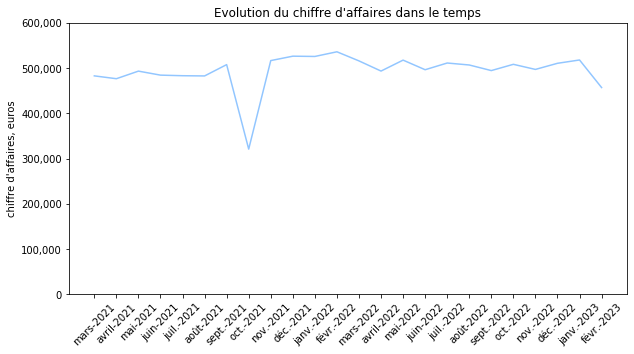

In [ ]:
# on crée une graphique pour montrer l'évolution du CA
fig=plt.figure(figsize=(10,5))
axes = plt.gca()
axes.set_ylim([0,600000])
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.plot(range(len(ca.index)), ca.values)
plt.xticks(range(len(ca.index)), pd.date_range('2021-03-01','2023-02-01', freq='MS').strftime("%b-%Y").tolist(), rotation=45)
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Evolution du chiffre d\'affaires dans le temps')
#plt.savefig('LaPage9.png', transparent=True, bbox_inches='tight')
plt.show()

On constate tout d’abord que le chiffre d'affaires s’est stabilisé au niveau de 500,000 euros par mois. Ensuite, les chiffres nous montrent une baisse notable en octobre 2021 et une baisse plus petite en février 2023.

#### **Tendances**

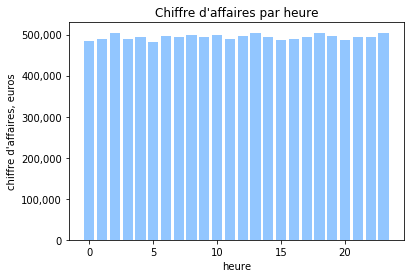

In [ ]:
# on calcule le CA par heure
tendance_heure=lapage_data.groupby('hour').agg({'product_price': np.sum}).rename(columns={'product_price': 'chiffre d\'affaires'})
# on les représente avec un diagramme à barres 
plt.bar(tendance_heure.index, tendance_heure['chiffre d\'affaires'].values)
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('heure')
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Chiffre d\'affaires par heure')
#plt.savefig('LaPage10.png', transparent=True, bbox_inches='tight')
plt.show()


Il n'y a pas de tendance. (Il est évident que les données sont automatiquement générées)


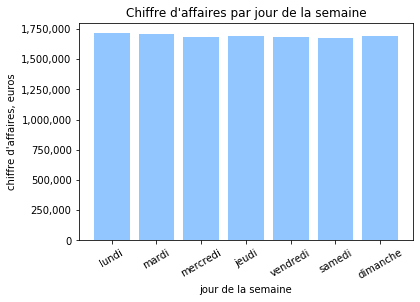

In [ ]:
# on calcule le CA par jour de la semaine
tendance_semaine=lapage_data.groupby('day_week_num').agg({'product_price': np.sum}).rename(columns={'product_price': 'chiffre d\'affaires'})
labels = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
# on les représente avec un diagramme à barres 
plt.bar(labels, tendance_semaine['chiffre d\'affaires'].values)
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('jour de la semaine')
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Chiffre d\'affaires par jour de la semaine')
plt.xticks(rotation=30)
#plt.savefig('LaPage11.png', transparent=True, bbox_inches='tight')
plt.show()


Il n'y a pas de tendance. (Il est évident que les données sont automatiquement générées)


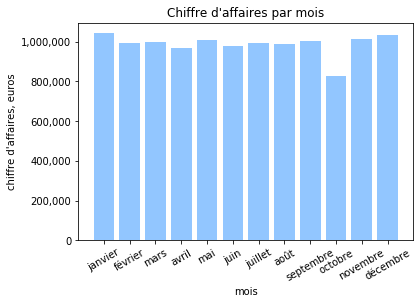

In [ ]:
# on calcule le CA par mois
tendance_mois=lapage_data.groupby('month').agg({'product_price': np.sum}).rename(columns={'product_price': 'chiffre d\'affaires'})
labels = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']
# on les représente avec un diagramme à barres 
plt.bar(labels, tendance_mois['chiffre d\'affaires'].values)
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('mois')
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Chiffre d\'affaires par mois')
plt.xticks(rotation=30)
#plt.savefig('LaPage12.png', transparent=True, bbox_inches='tight')
plt.show()


En octobre il y a une baisse de CA, comme on l'a vu avant. Sinon, il y a plus de CA en mois consistant de 31 jours.

(Il est évident que les données sont automatiquement générées)

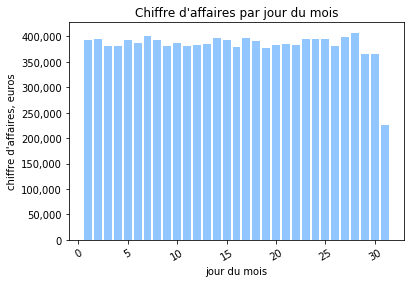

In [ ]:
# on calcule le CA par jour du mois
tendance_jour_mois=lapage_data.groupby('day').agg({'product_price': np.sum}).rename(columns={'product_price': 'chiffre d\'affaires'})
# on les représente avec un diagramme à barres 
plt.bar(tendance_jour_mois.index, tendance_jour_mois['chiffre d\'affaires'].values)
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('jour du mois')
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Chiffre d\'affaires par jour du mois')
plt.xticks(rotation=30)
#plt.savefig('LaPage13.png', transparent=True, bbox_inches='tight')
plt.show()


Il y a moins de CA pendant les jour à la fin du mois, parce que: seulement 7 mois contiennent le 31eme jour; le mois de février en 2022 et en 2023 ne consiste que de 28 jours. Grâce à cela le CA pour les jours 29 et 30 sont égales.

(Il est évident que les données sont automatiquement générées)

#### **Prédictions**

In [ ]:
# on calcule le CA par jour
ca_daily=lapage_data.groupby(['year', 'month', 'day']).agg({'product_price': np.sum}).rename(columns={'product_price': 'chiffre d\'affaires'})
ca_daily.reset_index(inplace=True)
# on crée un index avec la date
ca_daily['dateInt']=ca_daily['year'].astype(str) + ca_daily['month'].astype(str).str.zfill(2)+ ca_daily['day'].astype(str).str.zfill(2)
ca_daily.index = pd.date_range(start='2021-03-01', periods= 730, freq='D')
# on n'a besoin que de deux colonnes: date (index) et chiffre d'affaires (valeurs)
ca_daily.drop(columns=['year', 'month', 'day', 'dateInt'], inplace=True)
ca_daily.sort_index(inplace=True)

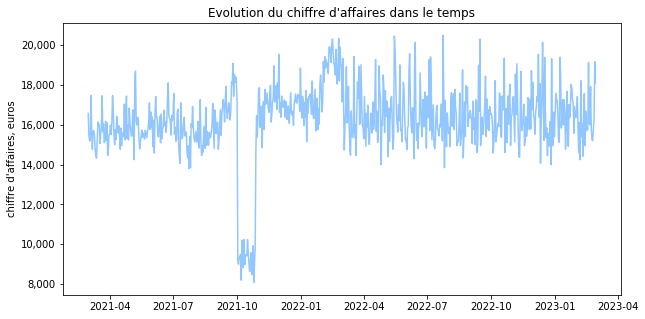

In [ ]:
# on construit un graphique pour avoir une idée de nos données
fig=plt.figure(figsize=(10,5))
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.plot(ca_daily.index, ca_daily.values)
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Evolution du chiffre d\'affaires dans le temps')
#plt.savefig('LaPage14.png', transparent=True, bbox_inches='tight')
plt.show()

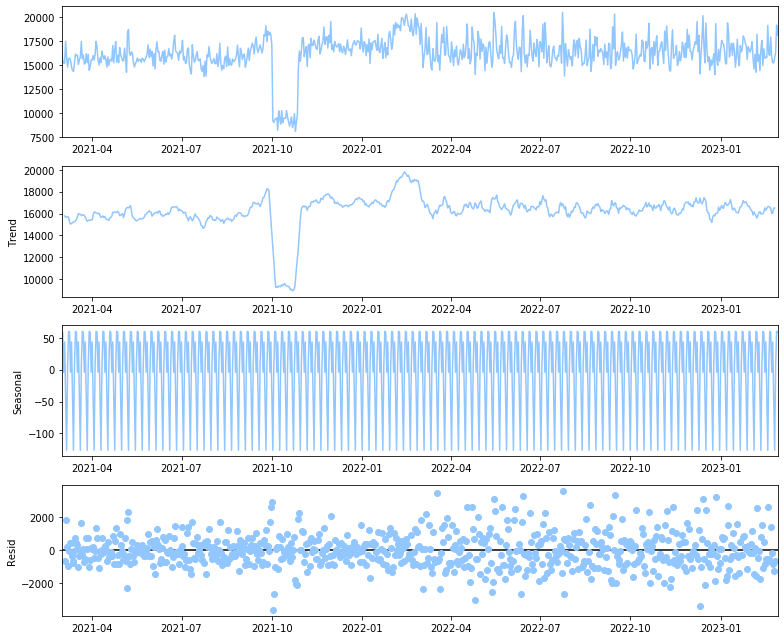

In [ ]:
# on analyse la saisonalité
rcParams['figure.figsize'] = 11, 9
decomposition=sm.tsa.seasonal_decompose(ca_daily, model='additive')
decomposition.plot()
#plt.savefig('LaPage15.png', transparent=True, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = 6.4, 4.8

On voit la saisonalité hebdomadaire, donc s=52

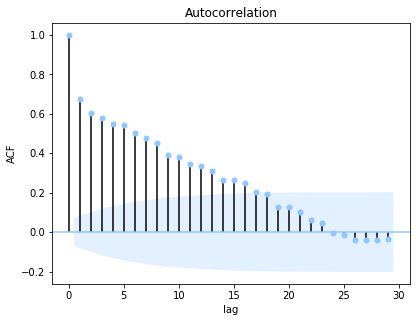

In [ ]:
plot_acf(ca_daily)
plt.xlabel('lag')
plt.ylabel('ACF')
#plt.savefig('LaPage16.png', transparent=True, bbox_inches='tight')
plt.show()

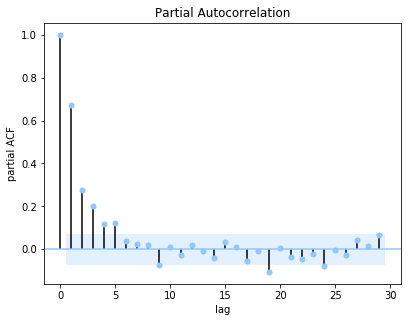

In [ ]:
plot_pacf(ca_daily)
plt.xlabel('lag')
plt.ylabel('partial ACF')
#plt.savefig('LaPage17.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# on va tester tous les modèles ARIMA possibles pour trouver le meilleur
d=q=p=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0], x[1], x[2], 52) for x in pdq]

In [ ]:
# On cherche le meilleur modèle (le meilleur modèle est celui possédant l’AIC le plusfaible)
AIC=50000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mdl = sm.tsa.statespace.SARIMAX(ca_daily, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            res = mdl.fit()
            if res.aic < AIC:
                AIC=res.aic
                best_param=param
                best_param_seasonal=param_seasonal
        except:
            continue
print('Le meilleur modèle est: ARIMA{}x{} - AIC:{}'.format(best_param, best_param_seasonal, AIC))

Le meilleur modèle est: ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:10827.61807731164


In [ ]:
# on construit un modèle et analyse les résultats
mdl = sm.tsa.statespace.SARIMAX(ca_daily, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52), enforce_stationarity=False, enforce_invertibility=False)
res = mdl.fit()
print(res.summary()) 

                                     SARIMAX Results                                      
Dep. Variable:                 chiffre d'affaires   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -5409.809
Date:                          jeu., 03 juin 2021   AIC                          10827.618
Time:                                    13:51:04   BIC                          10845.356
Sample:                                03-01-2021   HQIC                         10834.512
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1034      0.055      1.869      0.062      -0.005       0.212
ma.L1         -0.6945      0.041   

La deuxième colonne représente les coefficients du modèle. 
Puisque toutes les valeurs de P>|z| sont inférieurs à 0,05 (sauf ar.L1, qui est proche à 0.05), les résultats sont statistiquement significatifs. 

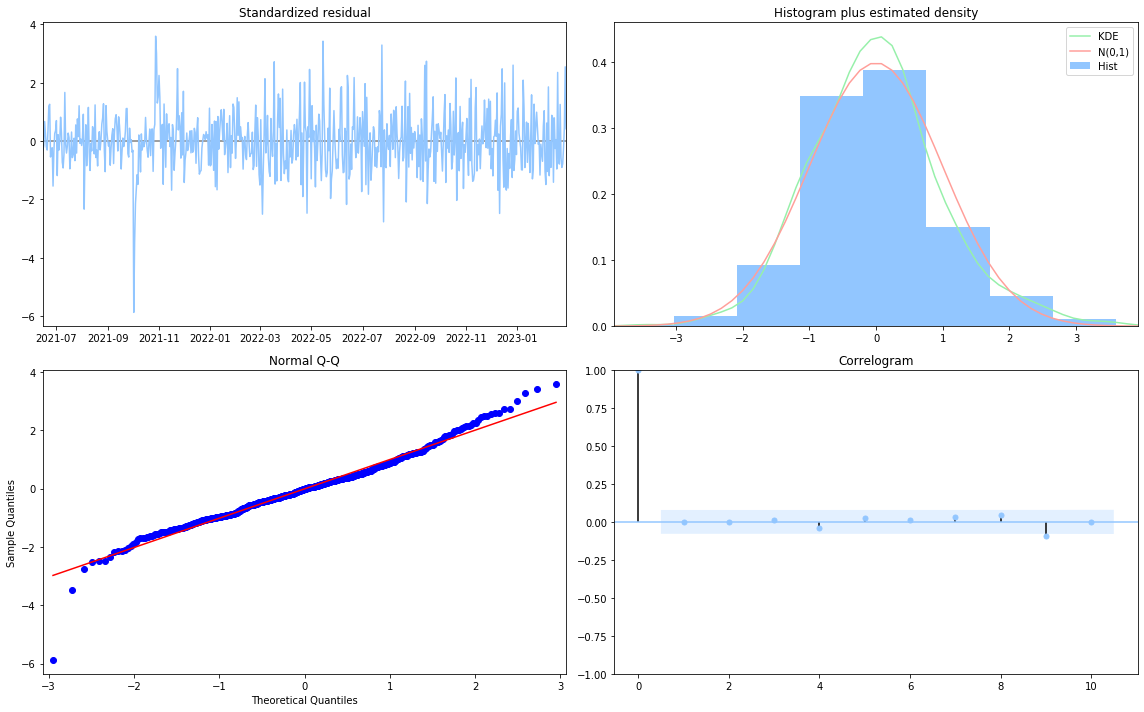

In [ ]:
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
#plt.savefig('LaPage18.png', transparent=True, bbox_inches='tight')
plt.show()

Les résidus au fil du temps sont indiqués sur la figure 'Standardized residual'. Les résultats impliquent que les résidus ne montrent aucune saisonnalité évidente et semblent être du bruit blanc. De même, l'autocorrélation représentée sur le corrélogramme implique que les résidus des données d'origine ont une faible corrélation avec les données retardées. Selon la figure 'Histogram plus estimated density', l'estimation de la densité du noyau (KDE) (courbe orange) est presque chevauchée avec le N (0, 1) (courbe verte). Les résultats impliquent que le résidu suit une distribution normale, avec une moyenne égale à 0 et un écart type égal à 1. Dans la figure 'Normal Q-Q', la ligne rouge représente un ensemble de données normalement distribué, avec une moyenne égale à 0 et un écart type égal à 1, tandis que les points bleus représentent les résidus. Le graphique Q-Q des résidus implique que les résidus suivent une tendance linéaire. Ainsi, les résidus sont normalement distribués. 

En général, le modèle montre une bonne précision de prévision et peut être utilisé pour prédire les valeurs futures. 

In [ ]:
# prédictions
pred = res.get_prediction(start = 1, end = 760, dynamic = False, full_results=True)
#intervalle de confiance
pred_ci=pred.conf_int()

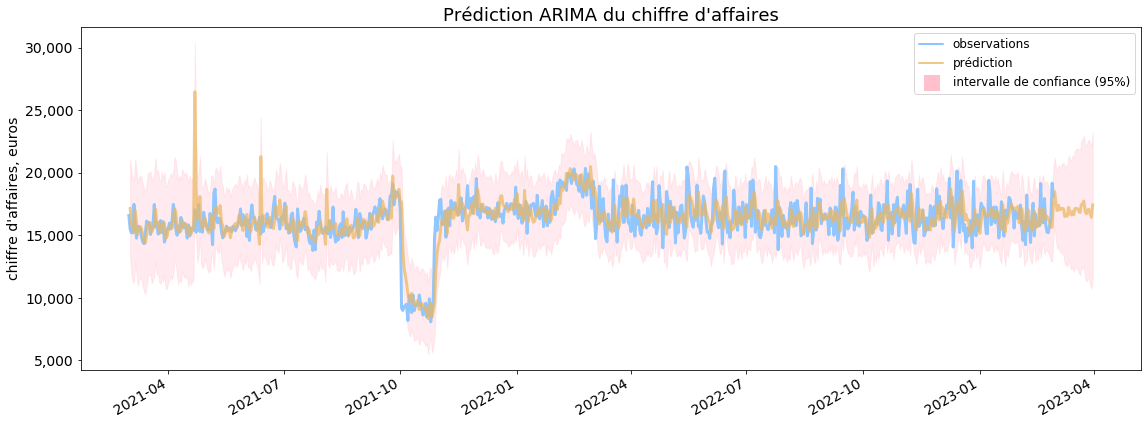

In [ ]:
fig = plt.figure(figsize=(19, 7))
ax = fig.add_subplot(111)
ax.plot(ca_daily, linewidth = 3, label='Observation');
pred.predicted_mean.plot(ax=ax,linewidth = 3, linestyle='-', label='Prediction', color='#EBB65E', alpha=.7, fontsize=14)
#intervalle de confiance
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=.3, color='pink')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('chiffre d\'affaires, euros', fontsize=14)
plt.legend(handles=[mlines.Line2D([], [], color='#66b3ff',markersize=15, label='observations'), 
                    mlines.Line2D([], [], color='#EBB65E',markersize=15, label='prédiction'),
                    mlines.Line2D([], [], marker="s", color='pink', linewidth=0, markersize=15, label='intervalle de confiance (95%)')], prop={'size': 12})
plt.title('Prédiction ARIMA du chiffre d\'affaires', fontsize=18)
#plt.savefig('LaPage19.png', transparent=True, bbox_inches='tight')
plt.show()


In [ ]:
# prédictions pour le mois de mars
fcast_res1 = res.get_forecast('2023-04-01')
print('CA prédiction pour mars 2023 (niveau de confiance = 95%)')
mars_m=round(sum(fcast_res1.summary_frame(alpha=0.05)['mean']))
mars_min=round(sum(fcast_res1.summary_frame(alpha=0.05)['mean_ci_lower']))
mars_max=round(sum(fcast_res1.summary_frame(alpha=0.05)['mean_ci_upper']))
print('Moyenne: {} euros'.format(mars_m))
print('Minimum: {} euros'.format(mars_min))
print('Maximum: {} euros'.format(mars_max))

# prédictions pour le mois d'avril
fcast_res2 = res.get_forecast('2023-05-01')
print('CA prédiction pour avril 2023 (niveau de confiance = 95%)')
avr_m=round(sum(fcast_res2.summary_frame(alpha=0.05)['mean']))-mars_m
avr_min=round(sum(fcast_res2.summary_frame(alpha=0.05)['mean_ci_lower']))-mars_min
avr_max=round(sum(fcast_res2.summary_frame(alpha=0.05)['mean_ci_upper']))-mars_max
print('Moyenne: {} euros'.format(avr_m))
print('Minimum: {} euros'.format(avr_min))
print('Maximum: {} euros'.format(avr_max))

CA prédiction pour mars 2023 (niveau de confiance = 95%)
Moyenne: 546160 euros
Minimum: 402059 euros
Maximum: 690261 euros
CA prédiction pour avril 2023 (niveau de confiance = 95%)
Moyenne: 521151 euros
Minimum: 313385 euros
Maximum: 728917 euros


In [ ]:
# on ajoute les valeurs prédites dans le tableau ca
ca.reset_index(inplace=True)
ca=ca.append(dict(zip(ca.columns, [2023, 3, mars_m])), ignore_index=True)
ca=ca.append(dict(zip(ca.columns, [2023, 4, avr_m])), ignore_index=True)
ca.set_index(['year', 'month'], inplace=True)

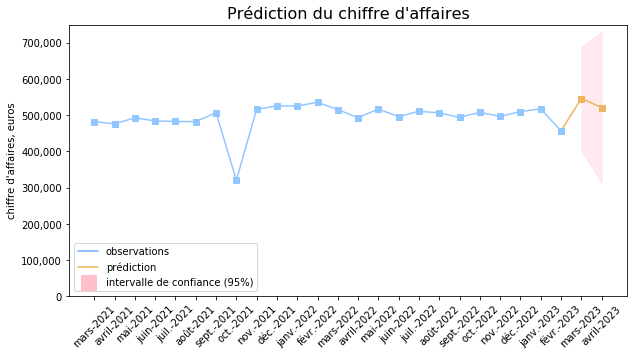

In [ ]:
# prédictions sur un graphique
fig=plt.figure(figsize=(10,5))
axes = plt.gca()
axes.set_ylim([0,750000])
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#prédictions + le dernier CA observé (pour connecter les points)
plt.plot(range(len(ca.index)-3, len(ca.index)), ca['chiffre d\'affaires'].values.tolist()[-3:], color='#EBB65E', marker='s')
#obsérvations
plt.plot(range(len(ca.index)-2), ca['chiffre d\'affaires'].values.tolist()[:-2], marker='s')

#intervalle de confiance
axes.fill_between(range(len(ca.index)-2, len(ca.index)), [mars_min, avr_min], [mars_max, avr_max], alpha=.3, color='pink')
plt.xticks(range(len(ca.index)), pd.date_range('2021-03-01','2023-04-01', freq='MS').strftime("%b-%Y").tolist(), rotation=45)
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Prédiction du chiffre d\'affaires', fontsize=16)
plt.legend(handles=[mlines.Line2D([], [], color='#66b3ff',markersize=15, label='observations'), 
                    mlines.Line2D([], [], color='#EBB65E',markersize=15, label='prédiction'),
                    mlines.Line2D([], [], marker="s", color='pink', linewidth=0, markersize=15, label='intervalle de confiance (95%)')], 
           loc='lower left')
#plt.savefig('LaPage20.png', transparent=True, bbox_inches='tight')
plt.show()


### **2. Analyse multivariée du chiffre d'affaires**<a class="anchor" id="section_2_2"></a>

#### **Le chiffre d'affaires par produit**

In [ ]:
#on crée un tableau avec tous les produits, leur prix, leur catégorie, nombre de ventes et CA
ca_par_produit=lapage_data.groupby('id_prod').agg({'product_price': np.sum, 'id_prod': 'count'}).rename(columns={'product_price': 'chiffre d\'affaires', 'id_prod': 'nombre d\'achats'})
ca_par_produit=pd.merge(ca_par_produit, products, left_index=True, right_index=True, how='left')

# le top-10 livres selon leur contribution au chiffre d'affaires
display(ca_par_produit.sort_values(by='chiffre d\'affaires', ascending=False).head(10).style.format({'categ': "{:.0f}", 'price':"{:.2f}", 'chiffre d\'affaires': "{:,.2f}"}))

,chiffre d'affaires,nombre d'achats,price,categ
id_prod,,,,
2_159,"94,893.50",650,145.99,2
2_135,"69,334.95",1005,68.99,2
2_112,"65,407.76",968,67.57,2
2_102,"60,736.78",1027,59.14,2
2_209,"56,971.86",814,69.99,2
1_395,"54,356.25",1875,28.99,1
1_369,"54,025.48",2252,23.99,1
2_110,"53,846.25",865,62.25,2
2_39,"53,060.85",915,57.99,2


Dans ce tableau on peut remarquer que 8 livres sur 10 sont de la catégorie 2. Ces 10 livres sont assez chers.

In [ ]:
# bestsellers
display(ca_par_produit.sort_values(by='nombre d\'achats', ascending=False).head(10).style.format({'categ': "{:.0f}", 'price':"{:.2f}", 'chiffre d\'affaires': "{:,.2f}"}))

,chiffre d'affaires,nombre d'achats,price,categ
id_prod,,,,
1_369,"54,025.48",2252,23.99,1
1_417,"45,947.11",2189,20.99,1
1_414,"51,949.40",2180,23.83,1
1_498,"49,731.36",2128,23.37,1
1_425,"35,611.04",2096,16.99,1
1_403,"35,260.40",1960,17.99,1
1_412,"32,484.15",1951,16.65,1
1_413,"34,990.55",1945,17.99,1
1_406,"48,106.59",1939,24.81,1


Dans ce tableau on peut remarquer que tous les bestsellers sont de la catégorie 1 avec le prix 16-25 euros.

R² = 0.8702882014397342
Y = 306.8395069341968 * e^(-0.0466423308376763 * x) + -1.1938895411927184


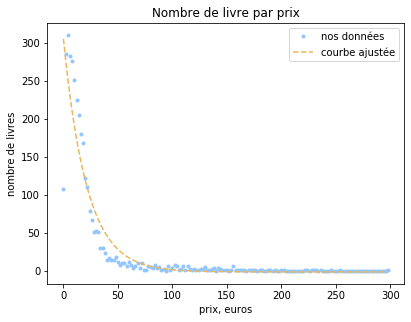

In [ ]:
# nous allons vérifier combien de livres nous avons par segment de prix 
# pour cela nous allons diviser toute la fourchette de prix en segments de longueur 2 euros et compter le nombre de livres pour chaque segment
prix=list(range(0, int(max(ca_par_produit['price'])), 2))
prix_count=[]
for i in prix:
    cp=len(ca_par_produit[(ca_par_produit['price']>i) & (ca_par_produit['price']<=(i+2))])
    prix_count.append(cp)
xs = np.array(prix)
ys = np.array(prix_count)

# on suppose que la fonction est exponentielle
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

# on effectue l'ajustement
p0 = (500, 0, 10)
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
m, t, b = params

# on determine la qualité d'ajustement
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")
print(f"Y = {m} * e^(-{t} * x) + {b}")

# on crée une graphique avec les résultats
plt.plot(xs, ys, '.', label='nos données')
plt.plot(xs, monoExp(xs, m, t, b), '--', label='courbe ajustée', color='#EBB65E')
plt.title('Nombre de livre par prix')
plt.xlabel('prix, euros')
plt.ylabel('nombre de livres')
plt.legend()
#plt.savefig('LaPage21.png', transparent=True, bbox_inches='tight')
plt.show()


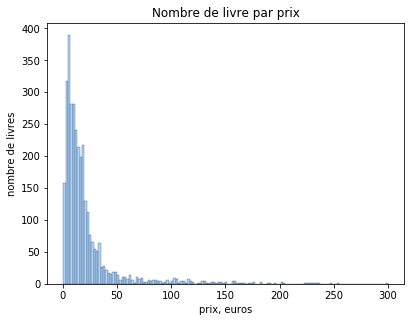

In [ ]:
# les même données mais avec une histogramme
sns.histplot(ca_par_produit['price'])
plt.title('Nombre de livre par prix')
plt.xlabel('prix, euros')
plt.ylabel('nombre de livres')
#plt.savefig('LaPage22.png', transparent=True, bbox_inches='tight')
plt.show()

La plupart de livres que l'on a sur le site web coûtent 0-25 euros. Les livres chers sont rares pour notre boutique.
Les prix de livres sont en effet exponentiellement distribuées.

R² = 0.662980993117889
Y = 61182.57229944902 * e^(-0.03996327703266865 * x) + -780.9781995507307


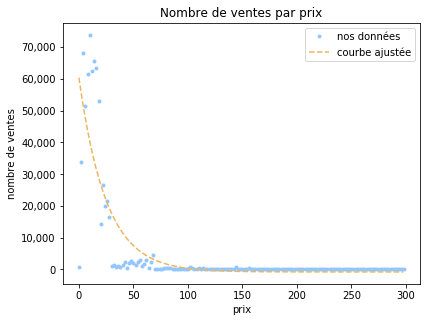

In [ ]:
# nous allons également vérifier s'il existe une corrélation entre le segment de prix et le nombre de ventes correspondant
prix_ventes_count=[]
for i in prix:
    cp=sum(ca_par_produit[(ca_par_produit['price']>i) & (ca_par_produit['price']<=(i+2))]['nombre d\'achats'])
    prix_ventes_count.append(cp)
xs = np.array(prix)
ys = np.array(prix_ventes_count)

# on effectue l'ajustement
p0 = (500, 0, 10)
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
m, t, b = params

# on determine la qualité d'ajustement
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")
print(f"Y = {m} * e^(-{t} * x) + {b}")

# on crée une graphique avec les résultats
plt.plot(xs, ys, '.', label='nos données')
plt.plot(xs, monoExp(xs, m, t, b), '--', label='courbe ajustée', color='#EBB65E')
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Nombre de ventes par prix')
plt.xlabel('prix')
plt.ylabel('nombre de ventes')
plt.legend()
#plt.savefig('LaPage23.png', transparent=True, bbox_inches='tight')
plt.show()

Selon le R² il y a une corrélation modérée. Pourtant, le graphique montre que c'est seulement les livres moins chers qui sont achetés généralement. Les livres chers ne sont achetés qu'exceptionnellement. Donc, personnellement, je n'observe pas de corrélation pour tous les livres et leur prix.

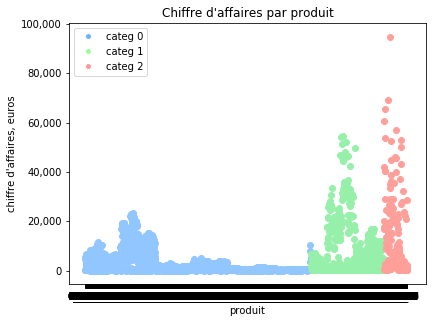

In [ ]:
# CA par produit
# le tableau croisé dynamique n'est pas très lisible, donc on va représenter toutes les données avec une graphique
# les produits sont triés par leur id_prod
# on va colorer les données selon la catégorie du produit
plt.scatter(ca_par_produit[ca_par_produit['categ']==0]['chiffre d\'affaires'].index, ca_par_produit[ca_par_produit['categ']==0]['chiffre d\'affaires'].values)
plt.scatter(ca_par_produit[ca_par_produit['categ']==1]['chiffre d\'affaires'].index, ca_par_produit[ca_par_produit['categ']==1]['chiffre d\'affaires'].values)
plt.scatter(ca_par_produit[ca_par_produit['categ']==2]['chiffre d\'affaires'].index, ca_par_produit[ca_par_produit['categ']==2]['chiffre d\'affaires'].values)
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Chiffre d\'affaires par produit')
plt.ylabel('chiffre d\'affaires, euros')
plt.xlabel('produit')

line1 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor='#66b3ff')
line2 = mlines.Line2D(range(1), range(1), color='white', marker='o',markerfacecolor='#99ff99')
line3 = mlines.Line2D(range(1), range(1), color='white', marker='o', markerfacecolor='#ff9999')
plt.legend((line1,line2,line3),('categ 0','categ 1', 'categ 2'),numpoints=1, loc='upper left')
#plt.savefig('LaPage24.png', transparent=True, bbox_inches='tight')
plt.show()


Nous voyons bien ces 8 livres de la catégorie 2 et 2 livres de la catégorie 1 qui ont apporté le plus de CA. Ils se trouve dans le quart supérieur droit du graphique. 
Nous voyons également que la plupart de livres de notre boutique sont les livres de la catégorie 0.

In [ ]:
ca_par_produit_sorted=ca_par_produit.sort_values(by='chiffre d\'affaires', ascending=False)

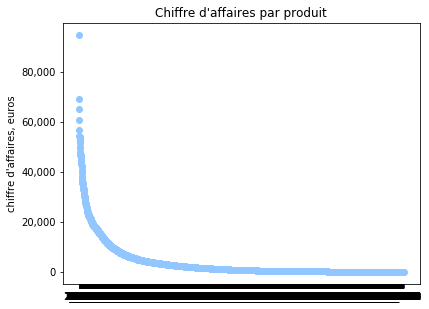

In [ ]:
# une autre représentation du CA par produit
# les produits sont triés par CA
plt.scatter(ca_par_produit_sorted['chiffre d\'affaires'].index, ca_par_produit_sorted['chiffre d\'affaires'].values)
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Chiffre d\'affaires par produit')
plt.ylabel('chiffre d\'affaires, euros')
#plt.savefig('LaPage25.png', transparent=True, bbox_inches='tight')
plt.show()

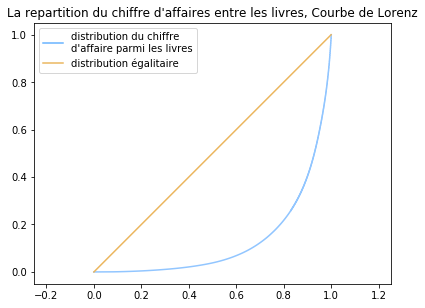

In [ ]:
# on va voir l'effet cumulatif et construire une courbe de Lorenz
ca_prod=ca_par_produit['chiffre d\'affaires'].values
n=len(ca_prod)
lorenz=np.cumsum(np.sort(ca_prod))/ca_prod.sum()
lorenz=np.append([0], lorenz)
plt.axes().axis('equal')
xaxis=np.linspace(0-1/n, 1+1/n, n+1)
plt.plot(xaxis, lorenz, drawstyle='steps-post')
plt.plot([0.0, 0.2, 0.4, 0.6, 0.8, 1.], [0.0, 0.2, 0.4, 0.6, 0.8, 1.], color='#EBB65E')
plt.title('La repartition du chiffre d\'affaires entre les livres, Courbe de Lorenz')
plt.legend(handles=[mlines.Line2D([], [], color='#66b3ff',markersize=15, label="distribution du chiffre  \nd'affaire parmi les livres"), 
                    mlines.Line2D([], [], color='#EBB65E',markersize=15, label="distribution égalitaire")])
#plt.savefig('LaPage26.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# on calcule le coefficient de Gini
AUC=(lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2)/n
S=0.5-AUC
gini=2*S
print(gini)

0.7428362669211792


Le coefficient de Gini nous montre qu'il y a une petite partie de livres qui apporte la plupart du chiffre d'affaires.

In [ ]:
# on va calculer quelle part du CA apportent 10% de livres ayant le plus grand CA
head=round(len(ca_par_produit_sorted)/10)
print('10.0% de tous les livres que l\'on vende apporte ', 
      round(sum(ca_par_produit_sorted.head(head)['chiffre d\'affaires'])/sum(ca_par_produit_sorted['chiffre d\'affaires']),1)*100,
     '% du CA.', sep='')

10.0% de tous les livres que l'on vende apporte 60.0% du CA.


#### **Le chiffre d'affaires par catégorie**

In [ ]:
# on calcule le CA par catégorie
cat_ca=lapage_data.groupby('product_categ').agg({'product_price': np.sum}).sort_values(by='product_categ', ascending=True).rename(columns={'product_price': 'chiffre d\'affaires'})
display(cat_ca.style.format({'product_categ': "{:.0f}", 'chiffre d\'affaires': "{:,.2f}"}))

,chiffre d'affaires
product_categ,
0,"4,422,008.38"
1,"4,653,722.69"
2,"2,780,275.02"


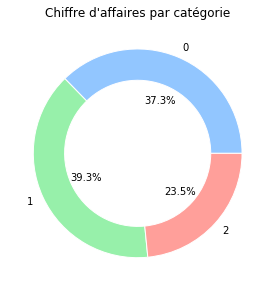

In [ ]:
# on représente le CA par catégorie avec l'aide d'un graphique circulaire 
fig, ax = plt.subplots()
wedges, text, autotext = ax.pie(cat_ca['chiffre d\'affaires'], labels=cat_ca.index, labeldistance=1.1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct='%1.1f%%', pctdistance=0.55)
# pour avoir un donut 
plt.setp( wedges, width=0.3)
plt.title('Chiffre d\'affaires par catégorie')
#plt.savefig('LaPage27.png', transparent=True, bbox_inches='tight')
plt.show()

Les catégories 1 et 0 apportent 76,5% du CA. La différence entre les deux est 5%. Pourtant la catégorie 2 fais également une contribution significative de 23,5%. 

In [ ]:
# on calcule le nombre d'achats par catégorie
cat_nomb=lapage_data.groupby('product_categ').agg({'product_price': 'count'}).sort_values(by='product_categ', ascending=True).rename(columns={'product_price': 'nombre d\'achats'})
display(cat_nomb.style.format({'product_categ': "{:.0f}", 'nombre d\'achats': "{:,.0f}"}))

,nombre d'achats
product_categ,
0,"415,680"
1,"227,169"
2,"36,483"


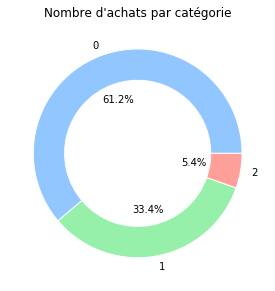

In [ ]:
# on représente le nombre d'achats par catégorie avec l'aide d'un graphique circulaire 
fig, ax = plt.subplots()
wedges, text, autotext = ax.pie(cat_nomb['nombre d\'achats'], labels=cat_nomb.index, labeldistance=1.1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct='%1.1f%%', pctdistance=0.55)
plt.setp( wedges, width=0.3)
plt.title('Nombre d\'achats par catégorie')
#plt.savefig('LaPage28.png', transparent=True, bbox_inches='tight')
plt.show()


Les livres de la catégorie 0 sont les plus vendus (61,2%). Les livres de la catégorie 2 sont moins nombreux et, par conséquent, sont moins vendus.
La différence des prix des catégories nous explique comment un petit secteur (5,4%) peut apporter un quart du CA et un grand secteur (61,2%) seulement 39,3%.

### <font color='red'>Test de comparaison</font> 

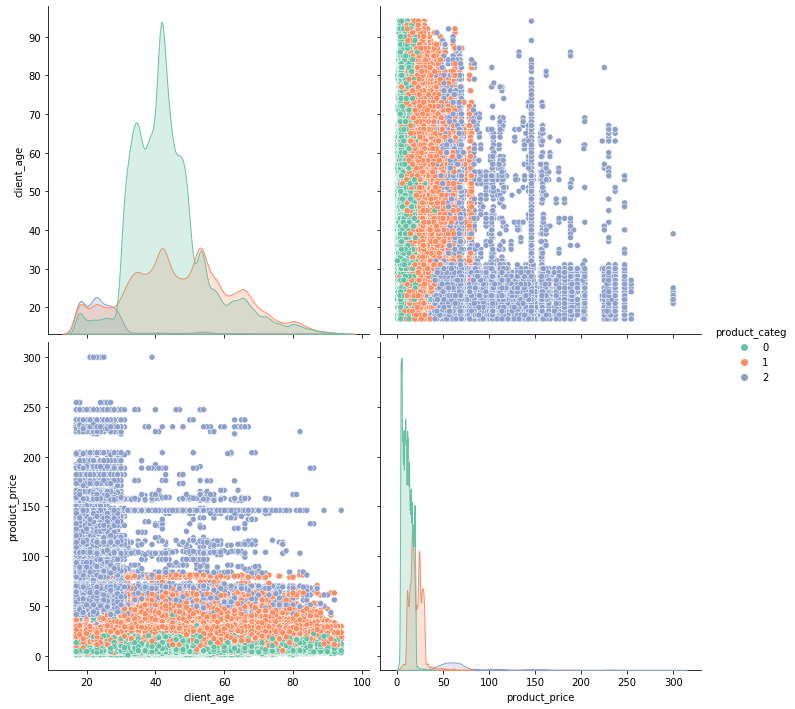

In [ ]:
# on va comparer les trois échantillons correspondant aux catégories
sns.pairplot(lapage_data[['product_categ', 'client_age', 'product_price']], hue='product_categ', palette='Set2', diag_kind='kde', height=5)
#plt.savefig('LaPage29.png', transparent=True, bbox_inches='tight')
plt.show()

Sur ces graphiques nous voyons bien que les échatillons correspondant à chaque catégorie sont très différents. 

### <font color='red'>Test de normalité</font> 

In [ ]:
# on teste l'hypothèse nulle que l'âge de clients qui achètent des livres de chaque catégorie suit une loi normale 
print(st.normaltest(lapage_data[lapage_data['product_categ']==0]['client_age']))
print(st.normaltest(lapage_data[lapage_data['product_categ']==1]['client_age']))
print(st.normaltest(lapage_data[lapage_data['product_categ']==2]['client_age']))

NormaltestResult(statistic=66206.11741045787, pvalue=0.0)
NormaltestResult(statistic=3864.657487954702, pvalue=0.0)
NormaltestResult(statistic=22280.0810171954, pvalue=0.0)


pvalue < 0,05, on rejette l'hypothèse de normalité au niveau de test 5%.

In [ ]:
# voyons maintenant l'évolution du CA par catégorie
# dans un tableau
group_cat_month=lapage_data.pivot_table('product_price', index=['year', 'month'], columns='product_categ', aggfunc='sum')

display(group_cat_month.style.format("{:,.2f}"))

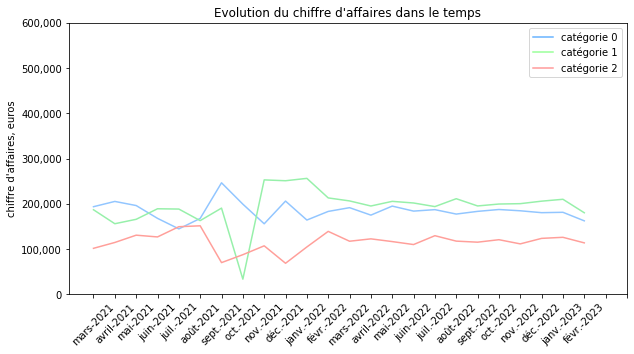

In [ ]:
# et dans un graphique
fig=plt.figure(figsize=(10,5))
axes = plt.gca()
axes.set_ylim([0,600000])
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.plot(range(len(group_cat_month.index)), group_cat_month)
plt.xticks(range(len(ca.index)), pd.date_range('2021-03-01','2023-02-01', freq='MS').strftime("%b-%Y").tolist(), rotation=45)
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Evolution du chiffre d\'affaires dans le temps')
plt.legend(handles=[mlines.Line2D([], [], color='#66b3ff',markersize=15, label="catégorie 0"), 
                    mlines.Line2D([], [], color='#99ff99',markersize=15, label="catégorie 1"),
                    mlines.Line2D([], [], color='#ff9999',markersize=15, label="catégorie 2")])
#plt.savefig('LaPage30.png', transparent=True, bbox_inches='tight')
plt.show()


Avec l'aide de ce graphique on peut expliquer la baisse du chiffre d'affaires en octobre 2021. En effet, cette baisse est liée à une baisse de ventes des livres de la catégorie 1.
Nous avons vu que le CA des livres de la catégorie 1 est plus bas que des ceux de la catégorie 0. Pourtant, sur le graphique, si on ne prend pas en compte le mois d'octobre, le CA de la catégorie 1 est presque toujours le plus grand.

In [ ]:
# avons-nous les données pour tous le jours du mois d'octobre ?
octobre_cat1=sorted(lapage_data[(lapage_data['month']==10) & (lapage_data['year']==2021) & (lapage_data['product_categ']==1)]['day'].unique().tolist())
print('En octobre 2021 les produits de la catégorie 1 ont été vendus seulement : le', end=' ')
print(*octobre_cat1, sep=' octobre, le ', end=' octobre')

En octobre 2021 les produits de la catégorie 1 ont été vendus seulement : le 1 octobre, le 28 octobre, le 29 octobre, le 30 octobre, le 31 octobre

Il faut vérifier avec le personnel, si c'est une erreur du système ou si l'absence de ventes est liée à une rupture du stock.
Pour le moment nous considérons que nos données sont correctes et on les garde.

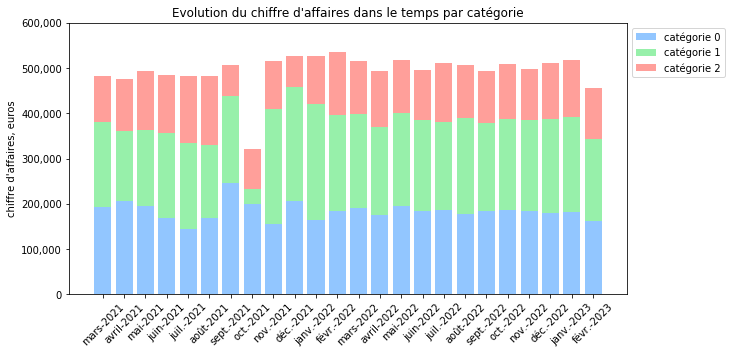

In [ ]:
# pour mieux voir la répartition du CA parmi les catégories on va créer un autre graphique
labels = pd.date_range('2021-03-01','2023-02-01', freq='MS').strftime("%b-%Y").tolist()
cat0 = group_cat_month[0].values
cat1 = group_cat_month[1].values
cat2 = group_cat_month[2].values

fig, ax = plt.subplots(figsize=(10,5))

ax.bar(labels, cat0, label='catégorie 0')
ax.bar(labels, cat1, bottom=cat0,label='catégorie 1')
ax.bar(labels, cat2, bottom=cat1+cat0,label='catégorie 2')

axes = plt.gca()
axes.set_ylim([0,600000])
plt.xticks(pd.date_range('2021-03-01','2023-02-01', freq='MS').strftime("%b-%Y").tolist(), pd.date_range('2021-03-01','2023-02-01', freq='MS').strftime("%b-%Y").tolist(), rotation=45)
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylabel('chiffre d\'affaires, euros')
ax.set_title('Evolution du chiffre d\'affaires dans le temps par catégorie')
ax.legend(bbox_to_anchor =(1, 1))
#plt.savefig('LaPage31.png', transparent=True, bbox_inches='tight')
plt.show()

#### **Baisse du CA en février**

In [ ]:
# Est-ce qu'il y a des jours où il n'y avait pas de ventes (oui, si le résultat est moins de 28)
fev_2023=lapage_data[(lapage_data['month']==2) & (lapage_data['year']==2023)]
fev_2023_groupe=fev_2023.groupby('day').agg({'product_price': 'sum', 'product_categ' : 'count'})
len(fev_2023_groupe)

28

In [ ]:
# Est-ce que le nombre de ventes moyen est plus bas en février, qu'en janvier ?
jan_2023=lapage_data[(lapage_data['month']==1) & (lapage_data['year']==2023)]
jan_2023_groupe=jan_2023.groupby('day').agg({'product_price': 'sum', 'product_categ' : 'count'})
print('Nombre de ventes moyen en janvier :', np.mean(jan_2023_groupe['product_categ']))
print('Nombre de ventes moyen en février :', np.mean(fev_2023_groupe['product_categ']))

Nombre de ventes moyen en janvier : 933.7096774193549
Nombre de ventes moyen en février : 912.5714285714286


Il n'y a pas d'explication visible à ce phénomène.

#### **Le chiffre d'affaires par genre des clients**

In [ ]:
# on calcule le CA et le nombre d'achats par genre
ca_par_sex=lapage_data.groupby('client_sex').agg({'client_id': pd.Series.nunique, 'product_price': np.sum, 'session_id': pd.Series.nunique}).rename(columns={'client_id': 'number_clients_uniques', 'product_price': 'chiffre d\'affaires', 'session_id': 'number_sessions'})
ca_par_sex['av_ca_per_session']=ca_par_sex['chiffre d\'affaires']/ca_par_sex['number_sessions']
display(ca_par_sex.style.format({'number_clients_uniques': "{:,.0f}", 'chiffre d\'affaires': "{:,.2f}", 'number_sessions': "{:,.0f}", 'av_ca_per_session': "{:.2f}"}))

,number_clients_uniques,chiffre d'affaires,number_sessions,av_ca_per_session
client_sex,,,,
f,"4,479","5,860,888.82","169,457",34.59
m,"4,121","5,995,117.27","172,858",34.68


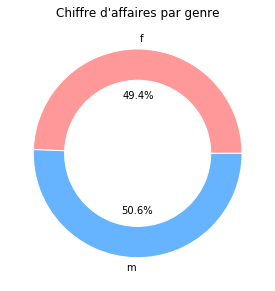

In [ ]:
# un graphique pour chiffre d'affaires par genre
fig, ax = plt.subplots()
wedges, text, autotext = ax.pie(ca_par_sex['chiffre d\'affaires'], labels=ca_par_sex.index, labeldistance=1.1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=['#ff9999','#66b3ff'], autopct='%1.1f%%', pctdistance=0.55)
plt.setp( wedges, width=0.3)
plt.title('Chiffre d\'affaires par genre')
#plt.savefig('LaPage32.png', transparent=True, bbox_inches='tight')
plt.show()

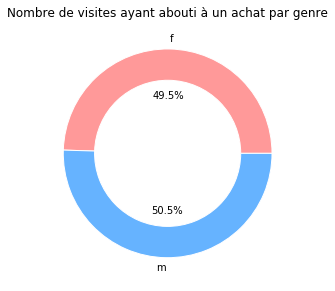

In [ ]:
# un graphique pour nombre de sessions par genre
fig, ax = plt.subplots()
wedges, text, autotext = ax.pie(ca_par_sex['number_sessions'], labels=ca_par_sex.index, labeldistance=1.1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=['#ff9999','#66b3ff'], autopct='%1.1f%%', pctdistance=0.55)
plt.setp( wedges, width=0.3)
plt.title('Nombre de visites ayant abouti à un achat par genre')
#plt.savefig('LaPage33.png', transparent=True, bbox_inches='tight')
plt.show()

Les représentatives de deux sexes se conduisent pareillement. Le nombre de clients uniques, le chiffre d'affaires, le nombre de visites ayant abouti à un achat varient très légèrement.

### <font color='red'>Test de comparaison</font> 

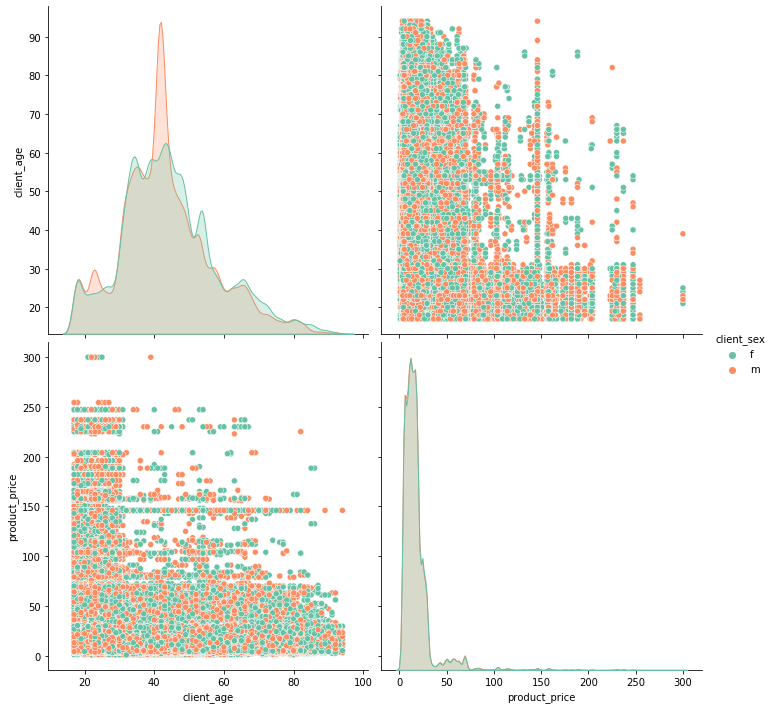

In [ ]:
# on va comparer les deux échantillons correspondant aux genres
sns.pairplot(lapage_data[['client_sex', 'client_age', 'product_price']], hue="client_sex", palette="Set2", diag_kind="kde", height=5)
#plt.savefig('LaPage34.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# on compare 2 variances: H0: les variances du prix d'achat pour les deux sexes sont égales
f=lapage_data[lapage_data['client_sex']=='f']['product_price']
m=lapage_data[lapage_data['client_sex']=='m']['product_price']
print('Pour l\'échantillon f nous avons: variance =', round(np.var(f, ddof=1),2), 'moyenne =', round(np.mean(f),2), 'taille =', len(f))
print('Pour l\'échantillon m nous avons: variance =', round(np.var(m, ddof=1),2), 'moyenne =', round(np.mean(m),2), 'taille =', len(m))

Pour l'échantillon f nous avons: variance = 319.52 moyenne = 17.32 taille = 338402
Pour l'échantillon m nous avons: variance = 352.04 moyenne = 17.58 taille = 340930


### <font color='red'>Test de normalité</font> 

In [ ]:
print(st.normaltest(f))
print(st.normaltest(m))

NormaltestResult(statistic=361347.37641192577, pvalue=0.0)
NormaltestResult(statistic=358618.30696798244, pvalue=0.0)


pvalue < 0,05, on rejette l'hypothèse de normalité au niveau de test 5%. Les deux distributions ne remplissent pas les conditions de normalité. Nous allons proceder à un test non-parametrique.

### <font color='red'>Mann–Whitney U test</font> 

In [ ]:
# test non-parametrique pour tester l'hypothèse selon laquelle les médianes de chacun de deux groupes de données sont proches
st.mannwhitneyu(f, m)

MannwhitneyuResult(statistic=57653465561.5, pvalue=0.3449956922854298)

pvalue > 0,05, on ne peut pas rejeter l'hypothèse 0. Les médianes de prix du panier de femmes et d'hommes sont proches.

### **3. La répartition du chiffre d'affaires entre les clients**<a class="anchor" id="section_2_3"></a>

In [ ]:
# on calcule CA, nombre de visites ayant abouti à un achat, nombre de produit achetés pour chaque client
ca_par_client=lapage_data.groupby('client_id').agg({'product_price': np.sum, 'session_id': pd.Series.nunique, 'product_categ': 'count'}).rename(columns={'product_price': 'chiffre d\'affaires', 'session_id': 'number_sessions', 'product_categ': 'number_books'})
ca_par_client['av_ca_per_session']=ca_par_client['chiffre d\'affaires']/ca_par_client['number_sessions']
ca_par_client=pd.merge(ca_par_client, customers, on='client_id')
# on détermine 10 client ayant apporté le plus de CA
display(ca_par_client.sort_values(by='chiffre d\'affaires', ascending=False).head(10).style.format({'chiffre d\'affaires': "{:,.2f}", 'number_sessions': "{:,.0f}", 'av_ca_per_session': "{:.2f}"}))

,chiffre d'affaires,number_sessions,number_books,av_ca_per_session,sex,birth,age
client_id,,,,,,,
c_1609,"324,033.35","10,997",25488,29.47,m,1980,43
c_4958,"289,760.34","3,851",5195,75.24,m,1999,24
c_6714,"153,660.75","2,620",9187,58.65,f,1968,55
c_3454,"113,668.85","5,573",6773,20.40,m,1969,54
c_3263,"5,276.87",143,403,36.90,f,1985,38
c_1570,"5,271.62",158,369,33.36,f,1979,44
c_2899,"5,214.05",69,105,75.57,f,1994,29
c_2140,"5,208.82",147,402,35.43,f,1977,46
c_7319,"5,155.77",145,371,35.56,f,1974,49


In [ ]:
#clients fidèles
loyal_clients=ca_par_client[ca_par_client['number_sessions']>200]
display(loyal_clients.style.format({'chiffre d\'affaires': "{:,.2f}", 'number_sessions': "{:,.0f}", 'number_books': "{:,.0f}", 'av_ca_per_session': "{:.2f}"}))

,chiffre d'affaires,number_sessions,number_books,av_ca_per_session,sex,birth,age
client_id,,,,,,,
c_1609,"324,033.35","10,997","25,488",29.47,m,1980,43
c_3454,"113,668.85","5,573","6,773",20.40,m,1969,54
c_4958,"289,760.34","3,851","5,195",75.24,m,1999,24
c_6714,"153,660.75","2,620","9,187",58.65,f,1968,55


In [ ]:
# combien de livres différents ces client fidèles ont achetés
print('Le client c_1609 a acheté', len(lapage_data[lapage_data['client_id']=='c_1609']['id_prod'].unique()), 'livres différents')
print('Le client c_3454 a acheté', len(lapage_data[lapage_data['client_id']=='c_3454']['id_prod'].unique()), 'livres différents')
print('Le client c_4958 a acheté', len(lapage_data[lapage_data['client_id']=='c_4958']['id_prod'].unique()), 'livres différents')
print('Le client c_6714 a acheté', len(lapage_data[lapage_data['client_id']=='c_6714']['id_prod'].unique()), 'livres différents')

Le client c_1609 a acheté 1920 livres différents
Le client c_3454 a acheté 1094 livres différents
Le client c_4958 a acheté 467 livres différents
Le client c_6714 a acheté 1381 livres différents


Nous avons 4 client fidèles qui ont acheté plusieurs milliers de livres dans notre magasin. Ces client ont acheté les mêmes livres plusieurs fois. Ces clients sont, très probablement, librairies eux-mêmes.

### <font color='red'>Test de normalité</font> 

NormaltestResult(statistic=1459.040963131712, pvalue=0.0)
NormaltestResult(statistic=1815.0827453380464, pvalue=0.0)
NormaltestResult(statistic=2829.664136982466, pvalue=0.0)
NormaltestResult(statistic=3422.233022250225, pvalue=0.0)


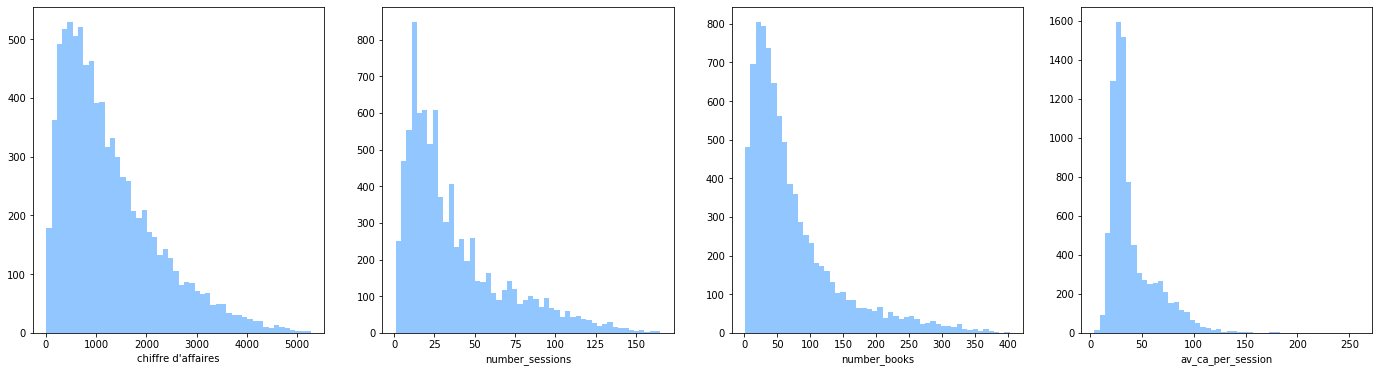

In [ ]:
# on teste l'hypothèse nulle que les variables du tableau ca_par_client suivent une loi normale 
d={1:'chiffre d\'affaires', 2: 'number_sessions', 3: 'number_books', 4: 'av_ca_per_session'}
fig=plt.figure(figsize=(24,6))
for i in range(4):
    fig.add_subplot(1,4,i+1)
    plt.hist(ca_par_client[ca_par_client['number_sessions']<200][d[i+1]], bins=50)
    plt.xlabel(d[i+1])
    print(st.normaltest(ca_par_client[ca_par_client['number_sessions']<200][d[i+1]]))

pvalue < 0,05, on rejette très largement l'hypothèse de normalité au niveau de test 5% pour toutes les variables, donc on ne peut pas utiliser les tests paramétriques pour ces veriables.

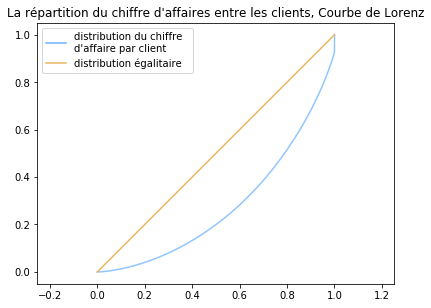

In [ ]:
# on va montrer la répartition du chiffre d'affaires entre les clients avec l'aide de la Courbe de Lorenz
ca_client=ca_par_client['chiffre d\'affaires'].values
n=len(ca_client)
lorenz=np.cumsum(np.sort(ca_client))/ca_client.sum()
lorenz=np.append([0], lorenz)
plt.axes().axis('equal')
xaxis=np.linspace(0-1/n, 1+1/n, n+1)
plt.plot(xaxis, lorenz, drawstyle='steps-post')
plt.plot([0.0, 0.2, 0.4, 0.6, 0.8, 1.], [0.0, 0.2, 0.4, 0.6, 0.8, 1.], color='#EBB65E')
plt.title('La répartition du chiffre d\'affaires entre les clients, Courbe de Lorenz')
plt.legend(handles=[mlines.Line2D([], [], color='#66b3ff',markersize=15, label="distribution du chiffre  \nd'affaire par client"), 
                    mlines.Line2D([], [], color='#EBB65E',markersize=15, label="distribution égalitaire")])
#plt.savefig('LaPage35.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# on calcule le coefficient de Gini
AUC=(lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2)/n
S=0.5-AUC
gini=2*S
print(gini)

0.44639520354209095


Le coefficient de Gini ne nous montre ni une situation égalitaire, ni une situation trop inégaletaire.

In [ ]:
# on va calculer quelle part du CA apportent 10% de clients ayant apporté le plus grand CA
head=round(len(ca_par_client)/10)
print('10.0% de tous les clients apporte ', 
      round(sum(ca_par_client.sort_values(by='chiffre d\'affaires', ascending=False).head(head)['chiffre d\'affaires'])/sum(ca_par_client['chiffre d\'affaires']),1)*100,
     '% du CA.', sep='')

10.0% de tous les clients apporte 30.0% du CA.


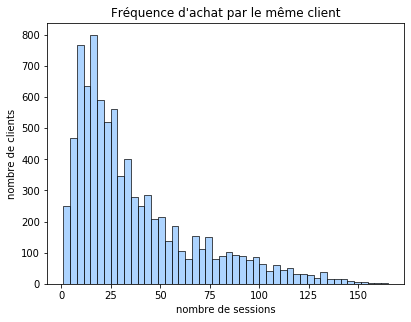

In [ ]:
# combien de clients visitent notre site web et achétent quelque chose le même nombre de fois
# on ne prend pas en compte nos clients-librairies
hist=ca_par_client[ca_par_client['number_sessions']<200]['number_sessions']
sns.histplot(hist)
plt.title('Fréquence d\'achat par le même client')
plt.xlabel('nombre de sessions')
plt.ylabel('nombre de clients')
#plt.savefig('LaPage36.png', transparent=True, bbox_inches='tight')
plt.show()

La plupart de clients a visité notre librairie et a acheté quelque chose 8-25 fois en 2 ans.

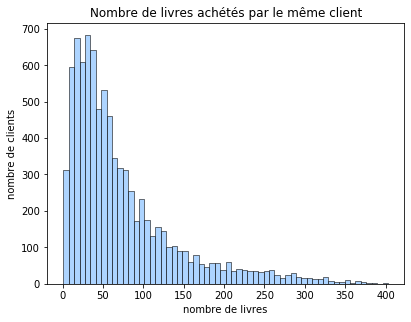

In [ ]:
# combien de client ont acheté le même nombre de livres
# on ne prend pas en compte nos clients-librairies
hist=ca_par_client[ca_par_client['number_books']<1000]['number_books']
sns.histplot(hist)
plt.title('Nombre de livres achétés par le même client')
plt.xlabel('nombre de livres')
plt.ylabel('nombre de clients')
#plt.savefig('LaPage37.png', transparent=True, bbox_inches='tight')
plt.show()

La plupart de nos clients a acheté moins de 55 livres en 2 ans.

## **Mission 2. Mission de Julie. Analyse ciblée sur les clients** <a class="anchor" id="chapter3"></a>

### **1. Le lien entre le genre d’un client et les catégories des livres achetés**<a class="anchor" id="section_3_1"></a>

In [ ]:
# on calcule le nombre de livres de chaque catégorie achetés par femmes et par hommes
sex_categ=lapage_data.pivot_table('id_prod', index='client_sex', columns='product_categ', aggfunc='count')
sex_categ

product_categ,0,1,2
client_sex,,,
f,206220,114899,17283
m,209460,112270,19200


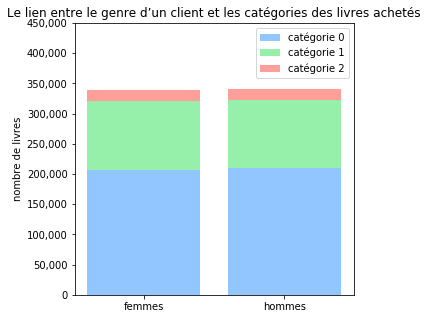

In [ ]:
# on représente ces données avec un diagramme à barres
labels = sex_categ.index
cat0 = sex_categ[0].values
cat1 = sex_categ[1].values
cat2 = sex_categ[2].values

fig, ax = plt.subplots(figsize=(5,5))

ax.bar(labels, cat0, label='catégorie 0')
ax.bar(labels, cat1, bottom=cat0,label='catégorie 1')
ax.bar(labels, cat2, bottom=cat1+cat0,label='catégorie 2')

axes = plt.gca()
axes.set_ylim([0,450000])
plt.xticks(['f', 'm'], ['femmes', 'hommes'])
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('nombre de livres')
ax.set_title('Le lien entre le genre d’un client et les catégories des livres achetés')
ax.legend()
#plt.savefig('LaPage38.png', transparent=True, bbox_inches='tight')
plt.show()

Il n'y a pas de lien visible entre le genre d'un client et les catégories des livres qu'il achète. La répartition par catégorie est la même pour les hommes et les femmes. Visiblement les deux sexes achètent des livres de catégories différentes avec la même fréquence. Nous allons tester cet hypothèse.

### <font color='red'>Test khi2</font> 

Nos données sont qualitatives et discrétes en même temps, donc on va utiliser le khi2 test.

In [ ]:
# on teste l'hypothèse nulle que les données catégorielles ont les mêmes fréquences 
st.chisquare(sex_categ.values)

Power_divergenceResult(statistic=array([ 25.25404157,  30.42510642, 100.7288052 ]), pvalue=array([5.02541541e-07, 3.47007835e-08, 1.05480377e-23]))

pvalue < 0,05, on rejette très largement l'hypothèse que les données ont les mêmes fréquences au niveau de test 5%

In [ ]:
# on teste l'indépendance des variables dans le tableau de contingence sex_categ
resultat=st.chi2_contingency(sex_categ.values)
print('Test khi2: %.2f' % resultat[0])
print('p-value: %.2f' % resultat[1])

Test khi2: 147.00
p-value: 0.00


pvalue < 0,05, on rejette très largement l'hypothèse d'indépendance des variables dans le tableau de contingence sex_categ au niveau de test 5%

Le test khi2 nous montre que ces deux échantillons ne suivent pas la même loi de probabilité et ne sont pas indépendants. Pourtant, il est utile pour nous de savoir que le comportement de ces deux échantillons se ressemble. 

#### **Le lien entre le genre d’un client et les livres achetés**

In [ ]:
# quels livres ont achetés par deux genres
livres_femmes=lapage_data[lapage_data['client_sex']=='f'][['id_prod', 'client_sex', 'product_price', 'product_categ']].drop_duplicates()
livres_hommes=lapage_data[lapage_data['client_sex']=='m'][['id_prod', 'client_sex', 'product_price', 'product_categ']].drop_duplicates()
livre_deux_sexes=pd.merge(livres_femmes.drop(columns='client_sex'), livres_hommes.drop(columns='client_sex'), how='inner')
livres_femmes.set_index('id_prod', inplace=True)
livres_hommes.set_index('id_prod', inplace=True)
livre_deux_sexes.set_index('id_prod', inplace=True)
livre_deux_sexes.sort_values('product_price')

,product_price,product_categ
id_prod,,
0_202,0.62,0
0_528,0.62,0
0_120,0.66,0
0_1844,0.77,0
0_1364,0.81,0
...,...,...
2_30,233.54,2
2_167,236.99,2
2_158,247.22,2


In [ ]:
#livres achetés seulement par les femmes
livres_seul_femmes=livres_femmes[~(livres_femmes.index.isin(livres_hommes.index))].sort_values('product_price')
livres_seul_femmes

,client_sex,product_price,product_categ
id_prod,,,
0_1539,f,0.99,0
0_898,f,1.27,0
0_1840,f,1.28,0
0_820,f,1.32,0
0_1806,f,1.61,0
...,...,...,...
2_28,f,103.50,2
2_23,f,115.99,2
2_129,f,127.99,2


In [ ]:
#livres achetés seulement par les hommes
livres_seul_hommes=livres_hommes[~(livres_hommes.index.isin(livres_femmes.index))].sort_values('product_price')
livres_seul_hommes

,client_sex,product_price,product_categ
id_prod,,,
0_643,m,0.99,0
0_1283,m,0.99,0
0_1653,m,0.99,0
0_1088,m,1.09,0
0_1284,m,1.38,0
...,...,...,...
2_131,m,127.99,2
2_130,m,142.58,2
2_77,m,145.99,2


Nous avons 3,266 livres au total. 3,092 sont unisexes, 86 livres sont pour les femmes, 88 - pour les hommes. Il y a aussi 21 livres qui n'intéressent pas du tout nos clients.

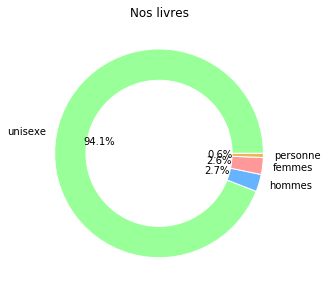

In [ ]:
fig, ax = plt.subplots()
wedges, text, autotext = ax.pie([len(livre_deux_sexes), len(livres_seul_hommes), len(livres_seul_femmes), 21], labels=['unisexe', 'hommes', 'femmes', 'personne'], labeldistance=1.1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=['#99ff99', '#66b3ff', '#ff9999', '#EBB65E'], autopct='%1.1f%%', pctdistance=0.58)
plt.setp( wedges, width=0.3)
plt.title('Nos livres')
#plt.savefig('LaPage39.png', transparent=True, bbox_inches='tight')
plt.show()


### **2. Le lien entre l’âge des clients et les autres variables**<a class="anchor" id="section_3_2"></a>

#### **Le lien entre l’âge des clients et le montant total des achats**

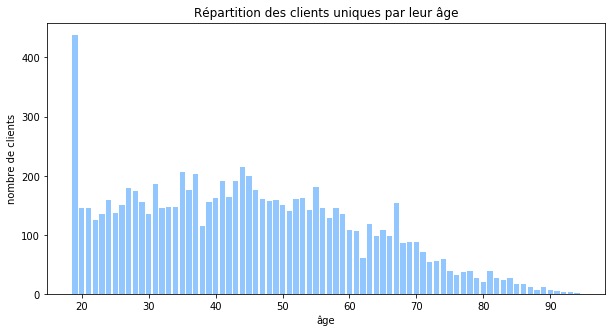

In [ ]:
# on calcule le nombre de client pour chaque âge (à ce jour, 1/03/2023)
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(customers.groupby(['age']).agg({'sex': 'count'}).rename(columns={'sex': 'nombre de clients'}).index,
       customers.groupby(['age']).agg({'sex': 'count'}).rename(columns={'sex': 'nombre de clients'})['nombre de clients'])
plt.xlabel('âge')
plt.ylabel('nombre de clients')
plt.title('Répartition des clients uniques par leur âge')
#plt.savefig('LaPage40.png', transparent=True, bbox_inches='tight')
plt.show()


Les clients ayant 19 ans sont surreprésentés dans notre base de données. Ce groupe d'âge est le plus nombreux. Par contre, les gens ayant 70 ans et plus sont sous-représentés. Ce qui pourrait être expliqué par plusieurs facteurs: <br>
&emsp;&emsp;il y a moins de gens âgés, en général, <br>
&emsp;&emsp;ces gens ne sont pas habitués à utiliser les nouvelles technologies, <br>
&emsp;&emsp;ces gens ont des problèmes avec leur vue, donc ils lisent moins<br>
&emsp;&emsp;parfois ce sont leurs enfants qui achètent des livres pour eux

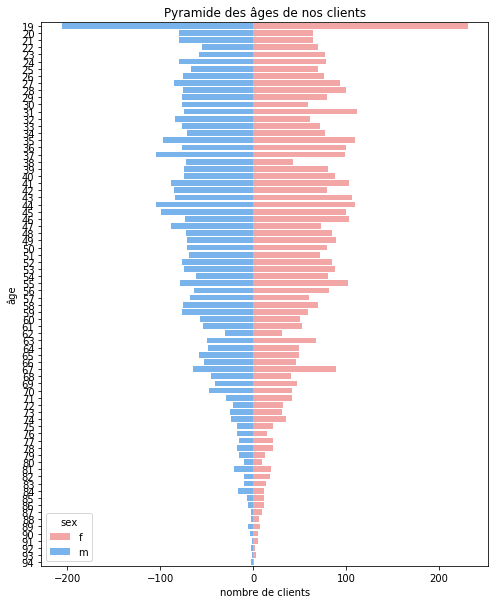

In [ ]:
# on calcule le nombre de client pour chaque âge (à ce jour, 1/03/2023) avec la répartition par genre 
cust_sex=customers.groupby(['age', 'sex']).agg({'birth': 'count'}).rename(columns={'birth': 'nombre de clients'})
cust_sex.reset_index(inplace=True)
# pour les hommes le nombre de clients sera negatif afin d'avoir une pyramide
cust_sex.loc[cust_sex['sex']=='m', 'nombre de clients']=cust_sex.loc[cust_sex['sex']=='m', 'nombre de clients']*(-1)

fig, ax = plt.subplots(figsize=(8,10))
# dodge=false -> les barres seront connectées à la base pour les hommes et pour les femmes
sns.barplot(data=cust_sex, x='nombre de clients', y='age', hue='sex', orient='horizontal', palette=['#ff9999','#66b3ff'], dodge=False)
plt.title('Pyramide des âges de nos clients')
plt.ylabel('âge')
#plt.savefig('LaPage41.png', transparent=True, bbox_inches='tight')
plt.show()


### <font color='red'>Test de normalité</font> 

In [ ]:
# on teste l'hypothèse nulle que le nombre de clients par sexe suit une loi normale
print(st.normaltest(customers[customers['sex']=='f']['age']))
print(st.normaltest(customers[customers['sex']=='m']['age']))

NormaltestResult(statistic=248.85109304303248, pvalue=9.176387357684597e-55)
NormaltestResult(statistic=263.57354205678655, pvalue=5.830859200667503e-58)


pvalue < 0,05, on rejette très largement l'hypothèse de normalité au niveau de test 5%.

In [ ]:
# on somme le CA par session, cela nous permettra de compter le nombre de sessions et l'analyser
session_group=lapage_data.groupby('session_id').agg({'product_price': np.sum, 'client_id': 'first', 'client_sex': 'first', 'client_birth': 'first', 'client_age': 'first', 'year': 'first', 'month': 'first', 'day': 'first', 'hour': 'first', 'day_week_num': 'first'}).rename(columns={'product_price': 'cart_price'})

In [ ]:
# on calcule le CA par âge (à moment d'achat)
ca_par_age=session_group.groupby('client_age').agg({'cart_price': np.sum}).rename(columns={'cart_price': 'chiffre d\'affaires'})
display(ca_par_age.style.format("{:,.2f}"))

,chiffre d'affaires
client_age,
17,"241,265.83"
18,"384,592.43"
19,"221,910.40"
20,"177,125.89"
21,"172,102.05"
22,"299,603.58"
23,"347,552.36"
24,"215,826.99"
25,"220,333.58"


### <font color='red'>Test de normalité</font> 

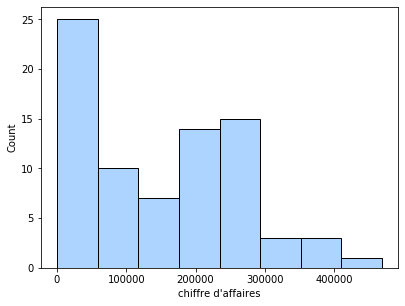

NormaltestResult(statistic=5.008410475558694, pvalue=0.08174053646682915)

In [ ]:
# on teste l'hypothèse nulle que le CA par âge suit une loi normale 
sns.histplot(ca_par_age['chiffre d\'affaires'])
plt.show()
st.normaltest(ca_par_age['chiffre d\'affaires'])

pvalue > 0,05, on ne peut pas rejeter l'hypothèse de normalité au niveau de test 5%. Donc, on peut essayer de modéliser le CA pour prédire son signification pour les mois prochains.

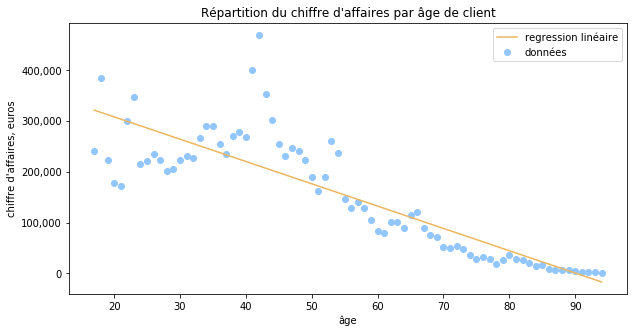

In [ ]:
# on représente le CA par âge sur un graphique
fig=plt.figure(figsize=(10,5))
lr=LinearRegression()
x=ca_par_age.index.values.reshape(-1,1)
y=ca_par_age.iloc[:,0].values.reshape(-1,1)
lr.fit(x, y)
ca_pred=lr.predict(x)
plt.scatter(ca_par_age.index, ca_par_age.values, label='données')
plt.plot(ca_par_age.index, ca_pred, label='regression linéaire', color='#EBB65E')
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('âge')
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Répartition du chiffre d\'affaires par âge de client')
plt.legend()
#plt.savefig('LaPage42.png', transparent=True, bbox_inches='tight')
plt.show()


Il y a des plusieurs pics correspondant à 18, 22 et 42 ans. Donc ce sont les gens ayant 17-55 ans qui sont nos clients principaux.

### <font color='red'>Test de Pearson</font> 

In [ ]:
# on calcule le coefficient de corrélation Pearson
st.pearsonr(ca_par_age.index, ca_par_age['chiffre d\'affaires'].values)[0]

-0.8566766700804982

La corrélation linéaire entre l’âge des clients et le montant total des achats est significative et négative. Plus la personne est âgée, moins elle va dépenser de l'argent.

### <font color='red'>Test de comparaison</font> 

In [ ]:
# nous allons vérifier comment change le comportement des clients dans un an
# pour cela on prend les données de la période 1 (mars 2021 - février 2022) et les compare âge par âge avec celles de la période 2 (mars 2022 - février 2023) 
ca_par_age_2021_2022=session_group[((session_group['year']==2021)&(session_group['month'].isin([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])))|
                                  ((session_group['year']==2022)&(session_group['month'].isin([1, 2])))].groupby('client_birth').agg({'cart_price': np.sum}).rename(columns={'cart_price': 'chiffre d\'affaires'})
ca_par_age_2021_2022['age']=2021-ca_par_age_2021_2022.index
ca_par_age_2021_2022.set_index('age', inplace=True)

ca_par_age_2022_2023=session_group[((session_group['year']==2022)&(session_group['month'].isin([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])))|
                                  ((session_group['year']==2023)&(session_group['month'].isin([1, 2])))].groupby('client_birth').agg({'cart_price': np.sum}).rename(columns={'cart_price': 'chiffre d\'affaires'})
ca_par_age_2022_2023['age']=2022-ca_par_age_2022_2023.index
ca_par_age_2022_2023.set_index('age', inplace=True)

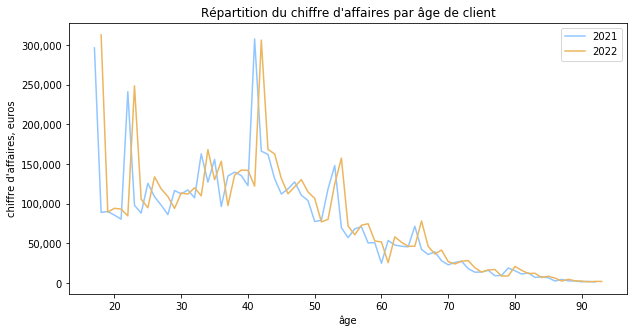

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.plot(ca_par_age_2021_2022.index, ca_par_age_2021_2022.values, label='2021')
plt.plot(ca_par_age_2022_2023.index, ca_par_age_2022_2023.values, label='2022', color='#EBB65E')
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('âge')
plt.ylabel('chiffre d\'affaires, euros')
plt.title('Répartition du chiffre d\'affaires par âge de client')
plt.legend()
#plt.savefig('LaPage43.png', transparent=True, bbox_inches='tight')
plt.show()


On voit bien la tendance ici. On va supprimer le lag de 1 an entre ces deux périodes et tester ces deux échantillons.

In [ ]:
# on ajoute 1 an à chaque personne du premier échantillon
ca_par_age_2021_2022['age_corr']=ca_par_age_2021_2022.index+1
ca_par_age_2021_2022.set_index('age_corr', inplace=True)
ca_par_age_year=pd.merge(ca_par_age_2021_2022, ca_par_age_2022_2023, left_index=True, right_index=True)

In [ ]:
# on calcule la corrélation entre cex deux échantillons
result = ca_par_age_year.corr()
print(result)

                      chiffre d'affaires_x  chiffre d'affaires_y
chiffre d'affaires_x              1.000000              0.998952
chiffre d'affaires_y              0.998952              1.000000


La corrélation est très forte.

In [ ]:
# on calcule la différence entre ces deux échantillons, âge par âge
ca_par_age_year['difference']=ca_par_age_year['chiffre d\'affaires_y']/ca_par_age_year['chiffre d\'affaires_x']-1
print('Au cours de l\'année l\'indicateur par âge a évolué de {:0.2%} en moyenne.'.format(round(ca_par_age_year['difference'].mean(), 4)))
print('L\'évolution maximale: {:0.2%}.'.format(round(ca_par_age_year['difference'].max(), 4)))
print('La baisse maximale: {:0.2%}.'.format(round(ca_par_age_year['difference'].min(), 4)))

Au cours de l'année l'indicateur par âge a évolué de 3.64% en moyenne.
L'évolution maximale: 47.83%.
La baisse maximale: -7.62%.


In [ ]:
session_group.loc[((session_group['year']==2021)&(session_group['month'].isin([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])))|
                                  ((session_group['year']==2022)&(session_group['month'].isin([1, 2]))), 'période']=1
session_group.loc[((session_group['year']==2022)&(session_group['month'].isin([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])))|
                                  ((session_group['year']==2023)&(session_group['month'].isin([1, 2]))), 'période']=2

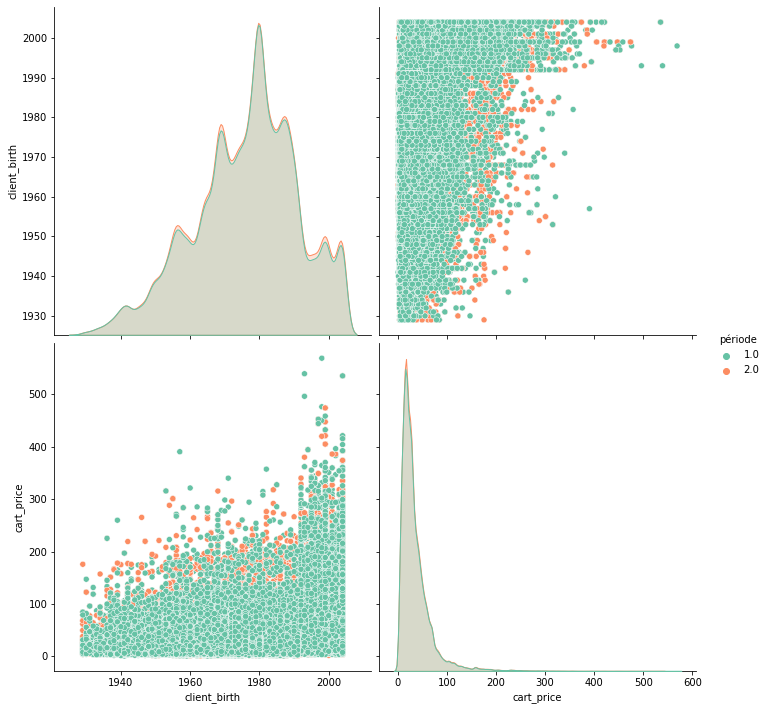

In [ ]:
# on va visualiser autrement la similarité de ces deux échantillons
sns.pairplot(session_group[['client_birth', 'cart_price', 'période']], hue='période', palette="Set2", diag_kind="kde", height=5)
#plt.savefig('LaPage44.png', transparent=True, bbox_inches='tight')
plt.show()

### <font color='red'>Test de normalité</font> 

In [ ]:
# on teste l'hypothèse nulle que le prix du panier par répriode suit une loi normale
print(st.normaltest(session_group[session_group['période']==1]['cart_price'].values))
print(st.normaltest(session_group[session_group['période']==2]['cart_price'].values))

NormaltestResult(statistic=125039.78181122274, pvalue=0.0)
NormaltestResult(statistic=126369.7794225803, pvalue=0.0)


pvalue < 0,05, on rejette très largement l'hypothèse de normalité au niveau de test 5%, donc on ne peut pas utiliser les tests paramétriques.

Nos deux échantillons ne sont pas normalement distribués. Donc, on est limité en termes de tests. On ne peut pas faire le t-test pour vérifier indépendance de deux échantillons, car il exige la distribution normale. Ensuite, pour faire le test d’adéquation (Kolmogorov-Smirnov dans le cas des données continues), on a besoin de deux échantillons indépendants.
On va faire les tests non-parametriques pour les données continues.

### <font color='red'>Mann–Whitney U test</font> 

In [ ]:
# on utilise un test statistique non-paramétrique qui permet de tester l'hypothèse selon laquelle les médianes de chacun de deux groupes de données sont proches
st.mannwhitneyu(session_group[session_group['période']==1]['cart_price'].values, session_group[session_group['période']==2]['cart_price'].values)

MannwhitneyuResult(statistic=14546671886.5, pvalue=0.0003136151969890757)

pvalue < 0,05, on rejette l'hypothèse que les médianes de prix du panier des groupes 2021 et 2022 sont proches au niveau de test 5%.

### <font color='red'>Test de Wilcoxon</font> 

In [ ]:
# on teste l'hypothèse nulle selon laquelle deux échantillons appariés liés proviennent de la même distribution 
# nos deux échatillons ici sont connectés à l'âge de clients
st.wilcoxon(ca_par_age_year['chiffre d\'affaires_x'], ca_par_age_year['chiffre d\'affaires_y'])

WilcoxonResult(statistic=314.0, pvalue=2.701514433682338e-09)

pvalue < 0,05, on rejette très largement l'hypothèse que la répartition du CA par âge des groupes 2021 et 2022 provient de la même distribution au niveau de test 5%.

### <font color='red'>Test de comparaison 2</font> 

On va essayer de tester deux échantillons appariés. Pour cela on prend les clients qui sont présents dans les deux périodes du temps et on compare le chiffre d'affaires que chacun entre eux nous a apporté en 2021 et en 2022 séparément. Enfin, on va comparer ces deux distributions du CA.

In [ ]:
clients_1=session_group[session_group['période']==1].groupby('client_id').agg({'cart_price': np.sum}).rename(columns={'cart_price': 'chiffre d\'affaires par client 2021'})
clients_1=clients_1[clients_1['chiffre d\'affaires par client 2021']<10000]
clients_2=session_group[session_group['période']==2].groupby('client_id').agg({'cart_price': np.sum}).rename(columns={'cart_price': 'chiffre d\'affaires par client 2022'})
clients_2=clients_2[clients_2['chiffre d\'affaires par client 2022']<10000]
clients_time=pd.merge(clients_1, clients_2, left_index=True, right_index=True, how='inner')

### <font color='red'>Test de normalité</font> 

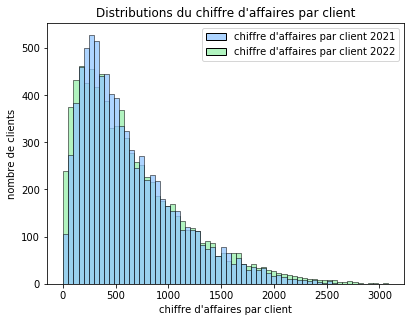

NormaltestResult(statistic=1406.8334990371952, pvalue=3.2358412405054247e-306)
NormaltestResult(statistic=1603.781413469907, pvalue=0.0)


In [ ]:
sns.histplot(clients_time)
plt.title('Distributions du chiffre d\'affaires par client')
plt.ylabel('nombre de clients')
plt.xlabel('chiffre d\'affaires par client')
#plt.savefig('LaPage45.png', transparent=True, bbox_inches='tight')
plt.show()
# on teste l'hypothèse nulle que le prix du panier par période suit une loi normale
print(st.normaltest(clients_time['chiffre d\'affaires par client 2021']))
print(st.normaltest(clients_time['chiffre d\'affaires par client 2022']))

pvalue < 0,05, on rejette très largement l'hypothèse de normalité au niveau de test 5%, donc on ne peut pas utiliser les tests paramétriques.

### <font color='red'>Test de Wilcoxon</font> 

In [ ]:
# on teste l'hypothèse nulle selon laquelle deux échantillons appariés liés proviennent de la même distribution 
st.wilcoxon(clients_time['chiffre d\'affaires par client 2021'], clients_time['chiffre d\'affaires par client 2022'])

WilcoxonResult(statistic=16132941.0, pvalue=3.8067337991432966e-15)

pvalue < 0,05, on rejette très largement l'hypothèse que les deux échantillons appariés proviennent de la même distribution au niveau de test 5%.

Les tests échouent. Pourtant nous voyons bien la tendance: les gens gardent leurs habitudes au fil du temps. C'est-à-dire, le prix du panier dépend plus d'année de naissance que d'âge actuel (la corrélation est plus forte pour l'anneé de naissance). Ces deux échantillons représente une série temporelle, avec un lag égal à 1 an.

#### **Le lien entre l’âge des clients et la fréquence d’achat**

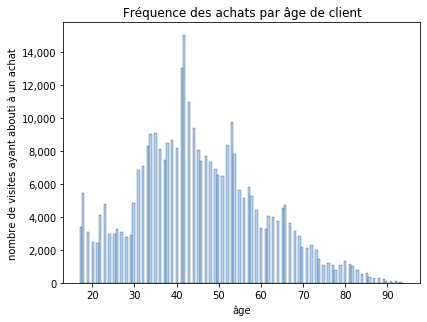

In [ ]:
# on représente le nombre de visites ayant abouti à un achat par âge (à moment d'achat) de clients avec un histogramme
sns.histplot(session_group['client_age'])
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('âge')
plt.ylabel('nombre de visites ayant abouti à un achat')
plt.title('Fréquence des achats par âge de client')
#plt.savefig('LaPage46.png', transparent=True, bbox_inches='tight')
plt.show()

### <font color='red'>Test de normalité</font> 

In [ ]:
# on teste l'hypothèse nulle que le nombre d'achats par âge suit une loi normale
print(st.normaltest(session_group['client_age']))

NormaltestResult(statistic=7551.218181106417, pvalue=0.0)


pvalue < 0,05, on rejette très largement l'hypothèse de normalité au niveau de test 5%.

### <font color='red'>Test de Pearson</font> 

In [ ]:
# on calcule le coefficient de corrélation Pearson
session_par_age=session_group.groupby('client_age').agg({'client_id': 'count'}).rename(columns={'client_id': 'nombre d\'achats'})
st.pearsonr(session_par_age.index, session_par_age['nombre d\'achats'].values)[0]

-0.583337034636244

La corrélation lineaire est négative et modérée. Pourtant avec l'aide du graphique on voit que c'est les personnes ayant 40-45 ans qui achètent le plus fréquemment. On peut également voir que les jeunes achètent nos produits moins souvent.

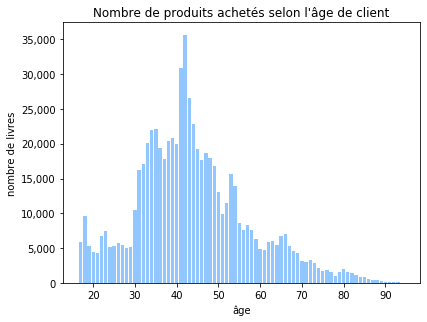

In [ ]:
# on calcule le nombre de produit achetés selon l'âge de client (à moment d'achat)
freq_par_age=lapage_data.groupby('client_age').agg({'id_prod': 'count'}).rename(columns={'id_prod': 'nombre de livres achetés'})
labels = freq_par_age.index.tolist()
# on les représente avec un diagramme à barres 
plt.bar(labels, freq_par_age['nombre de livres achetés'].values)
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('âge')
plt.ylabel('nombre de livres')
plt.title('Nombre de produits achetés selon l\'âge de client')
#plt.savefig('LaPage47.png', transparent=True, bbox_inches='tight')
plt.show()

### <font color='red'>Test de normalité</font> 

In [ ]:
# on teste l'hypothèse nulle que le nombre de prosuits achetés par âge suit une loi normale
print(st.normaltest(lapage_data['client_age']))

NormaltestResult(statistic=35282.31861310648, pvalue=0.0)


pvalue < 0,05, on rejette très largement l'hypothèse de normalité au niveau de test 5%

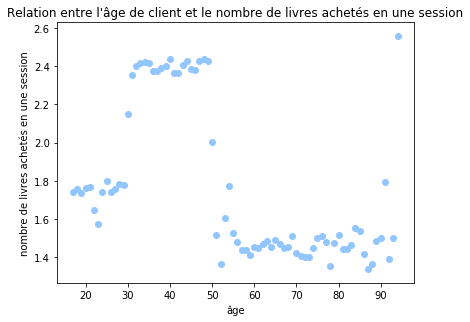

In [ ]:
# on crée un tableau avec le nombre de livres achetés au total et le nombre de sessions pour chaque âge
livres_par_session_age=pd.merge(freq_par_age, 
                                session_group.groupby('client_age').agg({'client_id': 'count'}).rename(columns={'client_id': 'nombre de sessions'}),
                                left_index=True, right_index=True)
# on calcule combien de livre en moyen un client achète par session selon son âge
livres_par_session_age['nomb_livres_moyen']=livres_par_session_age['nombre de livres achetés']/livres_par_session_age['nombre de sessions']

plt.scatter(livres_par_session_age.index, livres_par_session_age['nomb_livres_moyen'].values)
plt.xlabel('âge')
plt.ylabel('nombre de livres achetés en une session')
plt.title('Relation entre l\'âge de client et le nombre de livres achetés en une session')
#plt.savefig('LaPage48.png', transparent=True, bbox_inches='tight')
plt.show()

Visiblement, il y a trois tranches d'âge: 17-29, 30-49, 50+. Nous allons y retourner plus tard.

#### **Le lien entre l’âge des clients et la taille du panier moyen**

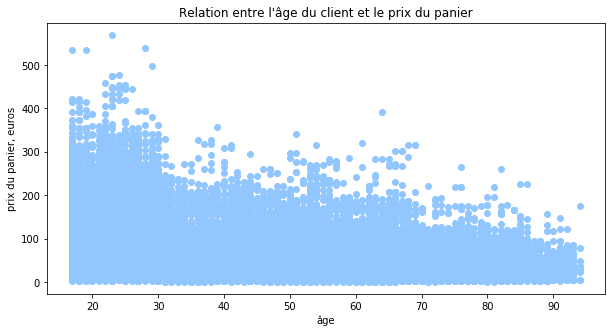

In [ ]:
# on veut montrer les prix du panier selon l'âge de client pour toutes les session depuis 2 ans
# chaque point répresente une session
fig=plt.figure(figsize=(10,5))
plt.scatter(session_group['client_age'], session_group['cart_price'])
plt.xlabel('âge')
plt.ylabel('prix du panier, euros')
plt.title('Relation entre l\'âge du client et le prix du panier')
#plt.savefig('LaPage49.png', transparent=True, bbox_inches='tight')
plt.show()

Apparemment les jeunes achètent moins de livres par session, mais ils achètent des livres chers.

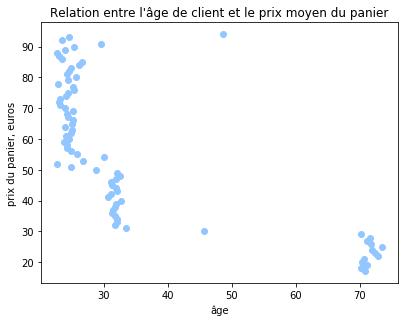

In [ ]:
# on calcule le prix moyen du panier pour chaque groupe d'âge
age_panier=session_group.groupby('client_age').agg({'cart_price': np.mean})
# chaque point correspond à un groupe d'âge
plt.scatter(age_panier.values, age_panier.index)
plt.xlabel('âge')
plt.ylabel('prix du panier, euros')
plt.title('Relation entre l\'âge de client et le prix moyen du panier')
#plt.savefig('LaPage50.png', transparent=True, bbox_inches='tight')
plt.show()

Ce graphique montre la même tendance: même si les jeunes achètent moins de livres par session, ils achètent des livres chers.

#### **Le lien entre l’âge des clients et les catégories des livres achetés**

In [ ]:
# on calcule le nombre de livres par catégorie pour tous les groupes d'âge
age_categ=lapage_data.pivot_table('id_prod', index='client_age', columns='product_categ', aggfunc='count')
age_categ.fillna(0, inplace=True)
age_categ

product_categ,0,1,2
client_age,,,
17,1400.0,2150.0,2385.0
18,2118.0,3721.0,3797.0
19,1161.0,2027.0,2221.0
20,992.0,1682.0,1758.0
21,1053.0,1574.0,1679.0
...,...,...,...
90,92.0,150.0,1.0
91,95.0,113.0,2.0
92,68.0,126.0,2.0


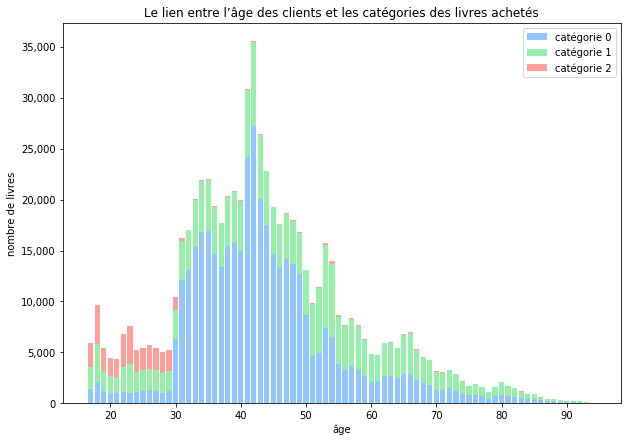

In [ ]:
# chaque colonne représente le nombre total de livres achetés par chaque groupe d'âge
# chaque colonne est divisée en trois parties selon les catégories de livres achetés
labels = age_categ.index.tolist()
cat0 = age_categ[0].values
cat1 = age_categ[1].values
cat2 = age_categ[2].values

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(labels, cat0, label='catégorie 0')
ax.bar(labels, cat1, bottom=cat0,label='catégorie 1')
ax.bar(labels, cat2, bottom=cat1+cat0,label='catégorie 2')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Le lien entre l’âge des clients et les catégories des livres achetés')
ax.legend(bbox_to_anchor =(1, 1))
plt.xlabel('âge')
plt.ylabel('nombre de livres')
#plt.savefig('LaPage51.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# on crée un tableau avec les répartitions des livres achetés par catégorie et par âge en pourcentage
# d'abord on crée une matrice avec les valeurs qui nous intéressent (0-1)
matrixArr1=np.empty((0, len(age_categ)), str)
for i in age_categ.index.tolist():
    sum_age=age_categ.loc[i].values.sum()
    currentList=[]
    for j in range(len(age_categ.columns)):
        currentList.append(age_categ.loc[i][j]/sum_age)
    matrixArr2 =np.array([currentList])
    if matrixArr1.size == 0:
        matrixArr1 = matrixArr2
    else:
        matrixArr1 = np.append(matrixArr1, matrixArr2, axis=0)

# on donne les nommes aux colonnes et aux tuples
cat_age_pourcentage=pd.DataFrame(data=matrixArr1, 
                                 index=age_categ.index.tolist(), 
                                 columns=[0, 1, 2])

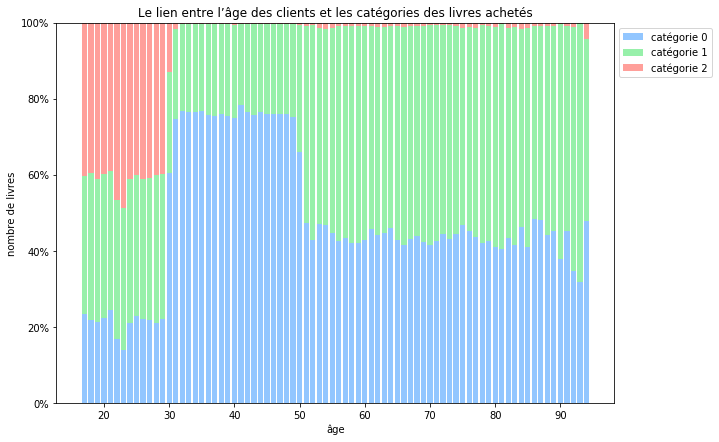

In [ ]:
# chaque colonne représente 100% de livres achetés par chaque groupe d'âge
# chaque colonne est divisée en trois parties selon les catégories de livres achetés
labels = age_categ.index.tolist()
cat0 = cat_age_pourcentage[0].values
cat1 = cat_age_pourcentage[1].values
cat2 = cat_age_pourcentage[2].values

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(labels, cat0, label='catégorie 0')
ax.bar(labels, cat1, bottom=cat0,label='catégorie 1')
ax.bar(labels, cat2, bottom=cat1+cat0,label='catégorie 2')
ax.set_title('Le lien entre l’âge des clients et les catégories des livres achetés')
plt.ylabel('nombre de livres')
plt.xlabel('âge')
ax.legend(bbox_to_anchor =(1, 1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=0))
#plt.savefig('LaPage52.png', transparent=True, bbox_inches='tight')
plt.show()

Ce graphique nous montre également l'existence de trois tranches d'âges. Elles sont les même que pour le graphique "Relation entre l'age du client et le nombre de livres achetés en une session": 17-29, 30-49, 50+. Maintenant nous allons analyser ces trois tranches.

### **3. Les statistiques par tranche d’âge**<a class="anchor" id="section_3_3"></a>

In [ ]:
# on regroupe les sessions selon la tranche d'âge
sessions_0_30=session_group[session_group['client_age']<30]
sessions_30_50=session_group[(session_group['client_age']>=30) & (session_group['client_age']<50)]
sessions_50_100=session_group[session_group['client_age']>=50]

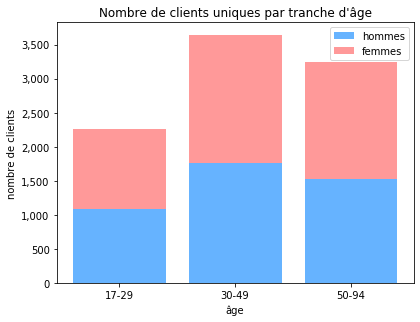

In [ ]:
# on calcule le nombre de clients qui se trouvent dans chaque tranche et on les divise par genre
labels = ['17-29', '30-49', '50-94']
femmes = [len(sessions_0_30[sessions_0_30['client_sex']=='f']['client_id'].unique()),
          len(sessions_30_50[sessions_30_50['client_sex']=='f']['client_id'].unique()), 
          len(sessions_50_100[sessions_50_100['client_sex']=='f']['client_id'].unique())]
hommes = [len(sessions_0_30[sessions_0_30['client_sex']=='m']['client_id'].unique()),
          len(sessions_30_50[sessions_30_50['client_sex']=='m']['client_id'].unique()), 
          len(sessions_50_100[sessions_50_100['client_sex']=='m']['client_id'].unique())]
fig, ax = plt.subplots()
ax.bar(labels, hommes, label='hommes', color='#66b3ff')
ax.bar(labels, femmes, bottom=hommes,label='femmes', color='#ff9999')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.xlabel('âge')
plt.ylabel('nombre de clients')
plt.title('Nombre de clients uniques par tranche d\'âge')
ax.legend(bbox_to_anchor =(1, 1))
#plt.savefig('LaPage53.png', transparent=True, bbox_inches='tight')
plt.show()


Les femmes et les hommes sont représentés également dans chaque tranche. Les jeunes sont moins nombreux, car la fourchette d'âge est deux fois plus petite que pour la tranche de 30-49 ans. 

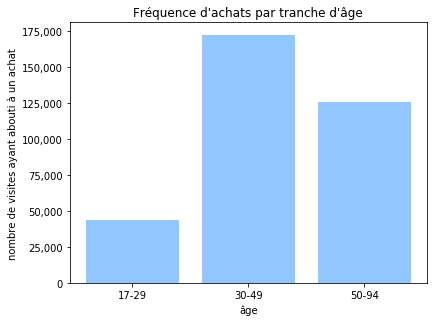

In [ ]:
# on calcule le nombre de visites ayant abouti à un achat par tranche d'âge
plt.bar([1, 2, 3], [len(sessions_0_30), len(sessions_30_50), len(sessions_50_100)], tick_label=['17-29', '30-49', '50-94'])
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('âge')
plt.ylabel('nombre de visites ayant abouti à un achat')
plt.title('Fréquence d\'achats par tranche d\'âge')
#plt.savefig('LaPage54.png', transparent=True, bbox_inches='tight')
plt.show()

Ce sont les gens de 30-49 qui achètent le plus souvent sur notre site web.

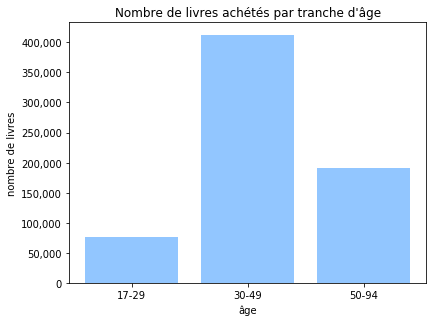

In [ ]:
# on calcule le nombre de livres achetés par tranche d'âge
livres_0_30=lapage_data[lapage_data['client_age']<30]
livres_30_50=lapage_data[(lapage_data['client_age']>=30) & (lapage_data['client_age']<50)]
livres_50_100=lapage_data[lapage_data['client_age']>=50]

plt.bar([1, 2, 3], [len(livres_0_30), len(livres_30_50), len(livres_50_100)], tick_label=['17-29', '30-49', '50-94'])
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('âge')
plt.ylabel('nombre de livres')
plt.title('Nombre de livres achétés par tranche d\'âge')
#plt.savefig('LaPage55.png', transparent=True, bbox_inches='tight')
plt.show()

Donc, les gens de 30-49 ans achétent plus souvent et plus de livres par session.

In [ ]:
# on calcule le nombre de livres de chaque catégorie achetés par chaque tranche d'âge
list_0_30=[0,0,0]
list_30_50=[0,0,0]
list_50_100=[0,0,0]
for i in age_categ.index:
    values_sum=age_categ.loc[age_categ.index==i].values.tolist()[0]
    if i <30:
        list_0_30=[x + y for x, y in zip(list_0_30, values_sum)]
    elif i<50:
        list_30_50=[x + y for x, y in zip(list_30_50, values_sum)]
    else:
        list_50_100=[x + y for x, y in zip(list_50_100, values_sum)]
tranches_ages_cat=pd.DataFrame(data=[list_0_30, list_30_50, list_50_100], index=['17-29', '30-49', '50-94'], columns=[0, 1, 2])
tranches_ages_cat

,0,1,2
17-29,15942.0,28498.0,31664.0
30-49,312469.0,96859.0,2959.0
50-94,87269.0,101812.0,1860.0


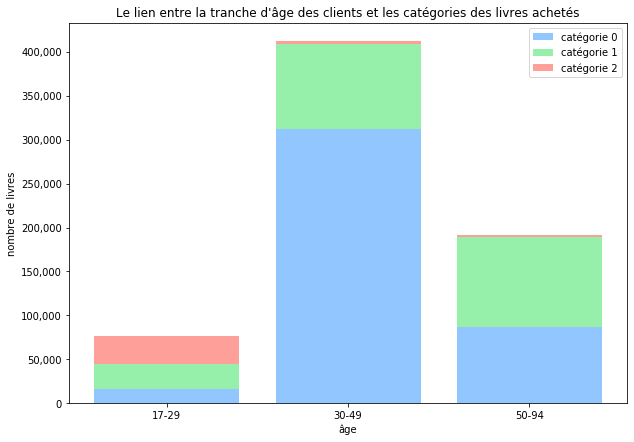

In [ ]:
# chaque colonne représente le nombre total de livres achetés par chaque tranche d'âge
# chaque colonne est divisée en trois parties selon les catégories de livres achetés
labels = tranches_ages_cat.index.tolist()
cat0 = tranches_ages_cat[0].values
cat1 = tranches_ages_cat[1].values
cat2 = tranches_ages_cat[2].values

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(labels, cat0, label='catégorie 0')
ax.bar(labels, cat1, bottom=cat0,label='catégorie 1')
ax.bar(labels, cat2, bottom=cat1+cat0,label='catégorie 2')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Le lien entre la tranche d\'âge des clients et les catégories des livres achetés')
ax.legend(bbox_to_anchor =(1, 1))
plt.xlabel('âge')
plt.ylabel('nombre de livres')
#plt.savefig('LaPage56.png', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# on crée un tableau avec les répartitions des livres achetés par les catégories et par tranche d'âge en pourcentage
# d'abord on crée une matrice avec les valeurs qui nous intéressent (0-1)
matrixArr3=np.empty((0, 3), str)
for i in ['17-29', '30-49', '50-94']:
    sum_age=tranches_ages_cat.loc[i].values.sum()
    currentList=[]
    for j in range(len(tranches_ages_cat.columns)):
        currentList.append(tranches_ages_cat.loc[i][j]/sum_age)
    matrixArr4 =np.array([currentList])
    if matrixArr3.size == 0:
        matrixArr3 = matrixArr4
    else:
        matrixArr3 = np.append(matrixArr3, matrixArr4, axis=0)

# on donne les nommes aux colonnes et aux tuples
cat_tranches_age_pourcentage=pd.DataFrame(data=matrixArr3, 
                                 index= ['17-29', '30-49', '50-94'], 
                                 columns=[0, 1, 2])
cat_tranches_age_pourcentage

,0,1,2
17-29,0.209477,0.374461,0.416062
30-49,0.757892,0.234931,0.007177
50-94,0.457047,0.533212,0.009741


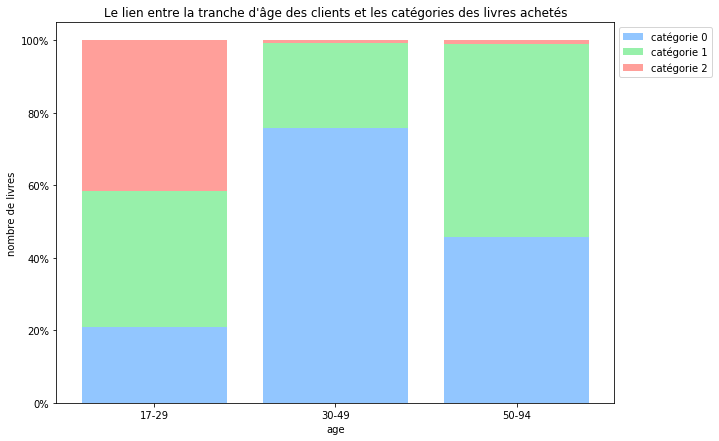

In [ ]:
# chaque colonne représente 100% de livres achetés par chaque tranche d'âge
# chaque colonne est divisée en trois parties selon les catégories de livres achetés
labels = cat_tranches_age_pourcentage.index.tolist()
cat0 = cat_tranches_age_pourcentage[0].values
cat1 = cat_tranches_age_pourcentage[1].values
cat2 = cat_tranches_age_pourcentage[2].values

fig, ax = plt.subplots(figsize=(10,7))
ax.bar(labels, cat0, label='catégorie 0')
ax.bar(labels, cat1, bottom=cat0,label='catégorie 1')
ax.bar(labels, cat2, bottom=cat1+cat0,label='catégorie 2')
ax.set_title('Le lien entre la tranche d\'âge des clients et les catégories des livres achetés')
plt.xlabel('age')
plt.ylabel('nombre de livres')
ax.legend(bbox_to_anchor =(1, 1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=0))
#plt.savefig('LaPage57.png', transparent=True, bbox_inches='tight')
plt.show()

Les livres de la catégorie 2 ne sont achetés que par les gens ayant 17-29 ans. Probablement, ces livres sont la littérature éducative, les manuels. Les gens de 30-49 ans sont généralement intéressés par livres de la catégorie 0. Les personnes âgés achètent des livres des catégories 0 et 1 plutôt également.

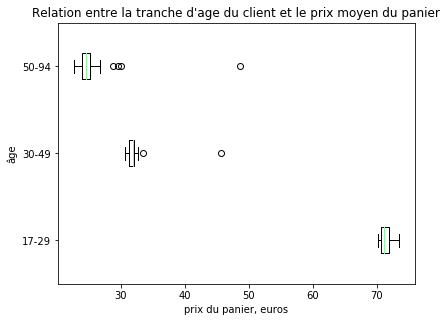

In [ ]:
# on calcule le prix moyen du panier pour chaque tranche d'âge
fig, ax = plt.subplots()
ax.boxplot([age_panier[age_panier.index<30]['cart_price'], age_panier[(age_panier.index>=30)&(age_panier.index<50)]['cart_price'], age_panier[age_panier.index>=50]['cart_price']], vert=False)
ax.set_yticklabels(['17-29', '30-49', '50-94'])
plt.xlabel('prix du panier, euros')
plt.ylabel('âge')
plt.title('Relation entre la tranche d\'age du client et le prix moyen du panier')
#plt.savefig('LaPage58.png', transparent=True, bbox_inches='tight')
plt.show()

Les jeunes achètent des livres de la catégorie 2 qui sont les plus chers. Le prix moyen du panier pour eux est plus que deux fois plus élevé que pour les gens de 30-49 ans.

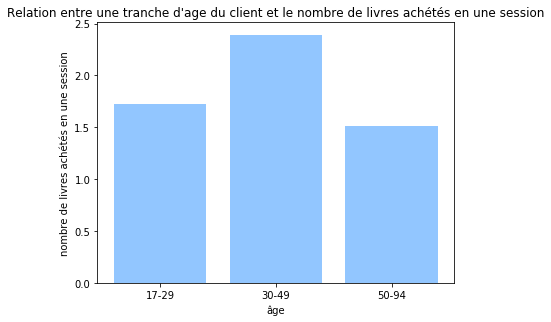

In [ ]:
# on calcule combien de livre en moyen un client achète par session selon sa tranche d'âge
plt.bar([1, 2, 3], [len(livres_0_30)/len(sessions_0_30), len(livres_30_50)/len(sessions_30_50), len(livres_50_100)/len(sessions_50_100)], tick_label=['17-29', '30-49', '50-94'])
plt.xlabel('âge')
plt.ylabel('nombre de livres achétés en une session')
plt.title('Relation entre une tranche d\'age du client et le nombre de livres achétés en une session')
#plt.savefig('LaPage59.png', transparent=True, bbox_inches='tight')
plt.show()

Les gens de 30-49 achètent le plus de livres par session en moyen (2,4). Les jeunes achètent 1,8 livres par session en moyen. Les personnes âgés achètent le moins de livres par session en moyens, 1,5 livres.

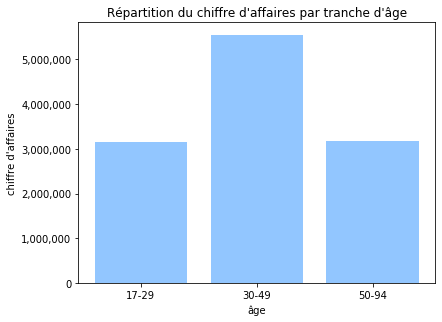

In [ ]:
# on calcule CA par tranche d'âge
plt.bar([1, 2, 3], [sum(sessions_0_30['cart_price']),sum(sessions_30_50['cart_price']), sum(sessions_50_100['cart_price'])], tick_label=['17-29', '30-49', '50-94'])
plt.xlabel('âge')
plt.ylabel('chiffre d\'affaires')
plt.title('Répartition du chiffre d\'affaires par tranche d\'âge')
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('âge')
#plt.savefig('LaPage65.png', transparent=True, bbox_inches='tight')
plt.show()

Les clients ayant 30-49 ans apportent plus de CA.

In [ ]:
# on va calculer le nombre de livres par âge
livres_30=lapage_data[lapage_data['client_age']<30][['client_id', 'id_prod', 'product_price', 'product_categ']]
livres_50=lapage_data[(lapage_data['client_age']>=30)&(lapage_data['client_age']<50)][['client_id', 'id_prod', 'product_price', 'product_categ']]
livres_100=lapage_data[lapage_data['client_age']>=50][['client_id', 'id_prod', 'product_price', 'product_categ']]
list30=pd.DataFrame(livres_30['id_prod'].unique(), columns=['id_prod'])
list50=pd.DataFrame(livres_50['id_prod'].unique(), columns=['id_prod'])
list100=pd.DataFrame(livres_100['id_prod'].unique(), columns=['id_prod'])

In [ ]:
livres_seul_30=len(list30[~((list30['id_prod'].isin(list50['id_prod']))|(list30['id_prod'].isin(list100['id_prod'])))])
livres_seul_50=len(list50[~((list50['id_prod'].isin(list30['id_prod']))|(list50['id_prod'].isin(list100['id_prod'])))])
livres_seul_100=len(list100[~((list100['id_prod'].isin(list50['id_prod']))|(list100['id_prod'].isin(list30['id_prod'])))])
print('Le nombre de livres achetés par toutes les tranches d\'âge:', 3266-livres_seul_30-livres_seul_50-livres_seul_100)
print('Le nombre de livres achetés seulement par les clients ayant 17-29 ans:', livres_seul_30)
print('Le nombre de livres achetés seulement par les clients ayant 30-49 ans:', livres_seul_50)
print('Le nombre de livres achetés seulement par les clients ayant 50-94 ans:', livres_seul_100)

Le nombre de livres achetés par toutes les tranches d'âge: 2967
Le nombre de livres achetés seulement par les clients ayant 17-29 ans: 48
Le nombre de livres achetés seulement par les clients ayant 30-49 ans: 232
Le nombre de livres achetés seulement par les clients ayant 50-94 ans: 19


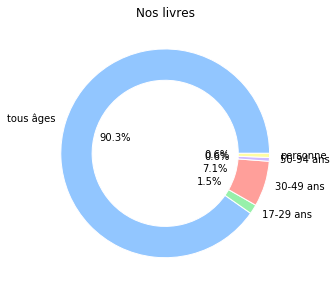

In [ ]:
fig, ax = plt.subplots()
wedges, text, autotext = ax.pie([(3266-livres_seul_30-livres_seul_50-livres_seul_100), livres_seul_30, livres_seul_50, livres_seul_100, 21], labels=['tous âges', '17-29 ans', '30-49 ans', '50-94 ans', 'personne'], labeldistance=1.1, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct='%1.1f%%', pctdistance=0.5)
plt.setp( wedges, width=0.3)
plt.title('Nos livres')
#plt.savefig('LaPage60.png', transparent=True, bbox_inches='tight')
plt.show()


### **4. La probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159**<a class="anchor" id="section_3_4"></a>

In [ ]:
# on crée deux listes avec les achats du livre 0_525 uniques et ceux du livre 2_159 (avec deux colonnes id_prod et client_id)
list_0_525=lapage_data[lapage_data['id_prod']=='0_525'][['id_prod', 'client_id']]
list_2_159=lapage_data[lapage_data['id_prod']=='2_159'][['id_prod', 'client_id']]
list_2_159.drop_duplicates(inplace=True)
list_0_525.drop_duplicates(inplace=True)

In [ ]:
# la probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159 est égal à :
# la probabité qu'un client a acheté les deux livres 
# divisée par 
# la probabilité qu'un client a acheté le livre 2_159 

# la probabilité qu'un client a acheté les deux livres 
intersection=pd.merge(list_0_525, list_2_159, how='inner', on='client_id')
probability_intersection=len(intersection)/len(lapage_data['client_id'].unique())
# la probabilité qu'un client a acheté le livre 2_159 
probability_2_159=len(list_2_159)/len(lapage_data['client_id'].unique())
# la probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159
probability_0_525_sach_2_159=probability_intersection/probability_2_159
print('La probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159 est %.2f' % probability_0_525_sach_2_159)

La probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159 est 0.87


## **Extra** <a class="anchor" id="chapter4"></a>

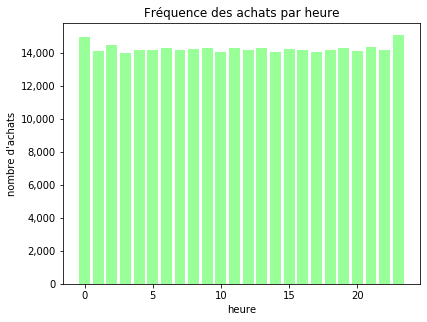

In [ ]:
# on calcule ne nombre d'achats par heure
plt.bar(session_group.groupby('hour').agg({'hour': 'count'})['hour'].index, session_group.groupby('hour').agg({'hour': 'count'})['hour'].values, color='#99ff99')
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Fréquence des achats par heure')
plt.ylabel('nombre d\'achats')
plt.xlabel('heure')
#plt.savefig('LaPage61.png', transparent=True, bbox_inches='tight')
plt.show()

Il n'y a pas de tendance. (Il est évident que les données sont automatiquement générées)

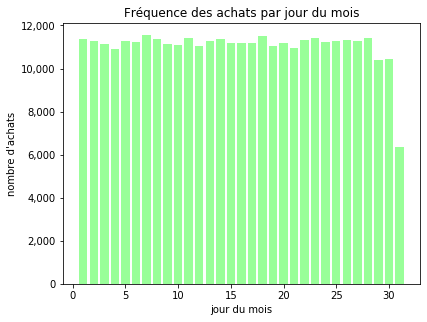

In [ ]:
# on calcule ne nombre d'achats par jour du mois
plt.bar(session_group.groupby('day').agg({'day': 'count'})['day'].index, session_group.groupby('day').agg({'day': 'count'})['day'].values, color='#99ff99')
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Fréquence des achats par jour du mois')
plt.ylabel('nombre d\'achats')
plt.xlabel('jour du mois')
#plt.savefig('LaPage62.png', transparent=True, bbox_inches='tight')
plt.show()

Il y a moins de ventes pendant les jour à la fin du mois, parce que: seulement 7 mois contiennent le 31eme jour ; le mois de février en 2022 et en 2023 ne consiste que de 28 jours. Grâce à cela le nombre de ventes pour les jours 29 et 30 sont égales.

(Il est évident que les données sont automatiquement générées)

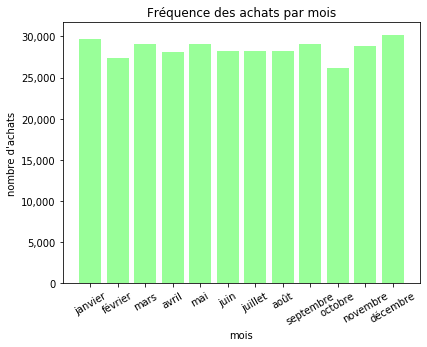

In [ ]:
# on calcule ne nombre d'achats par mois
labels = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']
plt.bar(labels, session_group.groupby('month').agg({'month': 'count'})['month'].values, color='#99ff99')
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Fréquence des achats par mois')
plt.ylabel('nombre d\'achats')
plt.xlabel('mois')
plt.xticks(labels, rotation=30)
#plt.savefig('LaPage63.png', transparent=True, bbox_inches='tight')
plt.show()

En octobre il y a une baisse de vente, comme on l'a vu avant. Sinon, il y a plus de ventes en mois consistant de 31 jours.

(Il est évident que les données sont automatiquement générées)

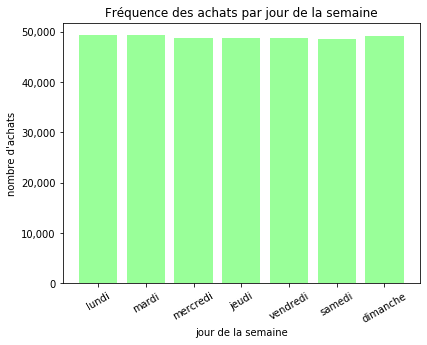

In [ ]:
# on calcule ne nombre d'achats par jour de la semaine
labels = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
plt.bar(labels, session_group.groupby('day_week_num').agg({'day_week_num': 'count'})['day_week_num'].values, color='#99ff99')
axes = plt.gca()
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Fréquence des achats par jour de la semaine')
plt.ylabel('nombre d\'achats')
plt.xlabel('jour de la semaine')
plt.xticks(labels, rotation=30)
#plt.savefig('LaPage64.png', transparent=True, bbox_inches='tight')
plt.show()

Il n'y a pas de tendance. (Il est évident que les données sont automatiquement générées)


## **Conclusion** <a class="anchor" id="chapter5"></a>

**Chiffre d’affaires**<br>
Le chiffre d’affaires total réalisé en ligne est de 11,856,006.09 euros. 
<br><br>
Le chiffre d'affaires s’est stabilisé au niveau de 500,000 euros par mois. Il a y eu une baisse notable en octobre 2021 et une baisse plus petite en février 2023. La première est liée à une baisse de ventes des livres de la catégorie 1. En octobre 2021, les produits de la catégorie 1 ont été vendus seulement : le 1 octobre, le 28 octobre, le 29 octobre, le 30 octobre, le 31 octobre. Il faut, donc, vérifier avec le personnel, si c'est une erreur du système ou si l'absence de ventes est liée à une rupture du stock. 
Il n'y a pas d'explication visible à une baisse du CA en février que l'on pourrait trouver dans notre base de données.
<br><br>
Les ventes sont uniformément réparties dans le temps (nous avons le même nombre de ventes et le même chiffre d’affaires pour tous les jours de la semaine, pour toutes les heures).
<br><br>
Les prédictions nous montrent qu’en mars on peut attendre le CA égal à 546,160 euros et en avril il sera 521,151 euros.
<br><br>
**Nos livres**<br>
Nous avons 3 catégories de livres : 0, 1, 2.  Les livres de la catégorie 0 sont les plus vendus (61,2%). Les livres de la catégorie 2 sont moins nombreux et moins vendus (5,4%). Pour la catégorie 0 la fourchette de prix est la plus petite. Pour la catégorie 2 elle est la plus grande. Le prix n’est pas normalement distribué. La différence des prix des catégories nous explique comment les livres de la catégorie 2, ne représentant que 5,4% de nombre de ventes peut apporter un quart du CA et les livres de la catégorie 0, représentant  61,2% apportent seulement 39,3% du CA.
<br><br>
Les livres que l'on achète plus souvent sont ceux qui coûtent moins cher et vice versa. Les plus populaires sont des livres des catégories 0 et 1 qui coûtent 0-25 euros. Car les livres de la catégorie 2 sont plus chers en général, on voit que ces livres sont plus souvent achetés s'ils coûtent autour de 50 euros.
<br><br>
Les prix des livres de notre boutique sont exponentiellement distribuées : la plupart de livres que l'on a sur le site web coûtent 0-25 euros, les livres chers sont rares pour notre boutique. De plus, les livres chers ne sont achetés qu'exceptionnellement. 
Le top-10 livres selon leur contribution au chiffre d'affaires sont assez chers. 8 livres sur 10 sont de la catégorie 2. 10% de tous les livres que l'on vende apporte 60% du CA. Par contre, les bestsellers sont de la catégorie 1 avec le prix 16-25 euros. 
<br><br>
Les livres de la catégorie 2 ne sont achetés que par les gens ayant 17-29 ans. Probablement, ces livres sont la littérature éducative, les manuels. Les gens de 30-49 ans sont généralement intéressés par livres de la catégorie 0. Les personnes âgés achètent des livres des catégories 0 et 1 plutôt également.
<br><br>
2,967 livres sont achetés par toutes les groupes d'âge. 48 livres - seulement par les clients ayant 17-29 ans. 232 - seulement par les clients ayant 30-49 ans. 19 - seulement par les clients ayant 50-94 ans.
<br><br>
En 2 ans on a vendu 679,332 livres. 
<br><br>
Nous avons 3,287 livres au total. 3,092 sont unisexes, 86 livres pour les femmes, 88 - pour les hommes et 21 livres qui apparemment n'intéressent pas nos clients. Parmi ces 21 livres :<br>
&emsp;&emsp;3 livres sont de la catégorie 2,<br>
&emsp;&emsp;2 livres sont de la catégorie 1,<br>
&emsp;&emsp;16 livres sont de la catégorie 0.<br>
Les prix varient de 0.8 à 221 euros. Donc, il faut analyser ces livres plus profondément pour trouver la raison pour laquelle ces livres ne sont pas vendus. Après un tel analyse on peut également prendre une décision de garder ces livres ou de ne plus les vendre.
<br><br>
La probabilité qu’un client achète la référence 0_525 sachant qu’il a acheté la référence 2_159 est 0,87
<br><br>
**Nos clients**<br>
Nous avons 8,600 clients ayant acheté quelque chose depuis 2 ans uniques et 23 clients qui n'ont jamais acheté de livres sur notre site web. Je peut supposer que les derniers préfèrent acheter des livres à une librairie physique. Ces clients sont d'âges différents, donc il est difficile de voir une tendance. Peut-être ces clients ne savent pas que notre librairie a ouvert un site de vente en ligne (dans ce cas il faut les contacter par e-mail, si on a leurs adresses mails), ou c'est aussi possible que ces clients ont deux comptes et n'en utilise qu'un.
<br><br>
Les clients ont visité notre site web et ont acheté quelque chose 342,315 fois.
<br><br>
Le CA n’est pas distribué dans une manière égalitaire entre nos clients : 10% de tous les clients apporte 30% du CA. Nous avons 4 client fidèles qui ont acheté plusieurs milliers de livres dans notre magasin. Ces client ont acheté les mêmes livres plusieurs fois. Ils sont, très probablement, librairies eux-mêmes
<br><br>
La plupart de clients a visité notre librairie et a acheté quelque chose 8-25 fois en 2 ans. La plupart entre eux a acheté moins de 55 livres en 2 ans.
<br><br>
Les représentatives de deux sexes se conduisent pareillement. Le nombre de clients uniques, le chiffre d'affaires, le nombre de visites ayant abouti à un achat varient très légèrement. Les médianes de prix du panier de femmes et d'hommes sont proches. Il n'y a pas de lien visible entre le genre d'un client et les catégories des livres qu'il achète. La répartition par catégorie est la même pour les hommes et les femmes. 
<br><br>
Concernant l’âge de nos clients, les clients ayant 19 ans sont les plus nombreux et même surreprésentés. Par contre, les gens ayant 70 ans et plus sont sous-représentés. Ce qui pourrait être expliqué par plusieurs facteurs : <br>
&emsp;&emsp;il y a moins de gens âgés, en général, <br>
&emsp;&emsp;ces gens ne sont pas habitués à utiliser les nouvelles technologies,<br> 
&emsp;&emsp;ces gens ont des problèmes avec leur vue, donc ils lisent moins<br>
&emsp;&emsp;parfois ce sont leurs enfants qui achètent des livres pour eux<br>
Donc ce sont les gens ayant 17-55 ans qui sont nos clients principaux. 
<br><br>
La corrélation linéaire entre l’âge des clients et le montant total des achats est significative et négative. Plus la personne est âgée, moins elle vas dépenser de l'argent. Pourtant, il y a une autre tendance plus importante : les gens gardent leurs habitudes au fil du temps. C'est-à-dire, le prix du panier dépend plus d'année de naissance que d'âge actuel. Nous avons une série temporelle, avec un lag égal à 1 an. 
<br><br>
Il existe trois tranches d'âges : 17-29, 30-49, 50+. Les femmes et les hommes sont représentés également dans chaque tranche. Les jeunes sont moins nombreux, car la fourchette d'âge est deux fois plus petite que pour la tranche de 30-49 ans. Les jeunes achètent nos produits moins souvent, avec moins de livres par session, mais ils achètent des livres chers. Le prix moyen du panier pour eux est plus que deux fois plus élevé que pour les gens de 30-49 ans. Les gens de 30-49 ans achètent plus souvent et plus de livres par session.